In [1]:
import os
import shutil
import random
import logging
import time
import json
from collections import defaultdict
from tempfile import TemporaryDirectory
from PIL import Image
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import RandAugment

import torchvision
from torchvision import models, transforms

# Configurations
cudnn.benchmark = True
plt.ion()  # interactive mode

# Logging Configuration
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

# Set random seed for reproducibility
manualSeed = 999
random.seed(manualSeed)
generator = torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

%set_env CUBLAS_WORKSPACE_CONFIG=:4096:8

env: CUBLAS_WORKSPACE_CONFIG=:4096:8


## Preparing a Balanced Subset of the Dataset

To speed up training while maintaining representativeness, we create a smaller, balanced dataset from our large collection (30K real, 90K fake images). We randomly sample 900 real and 900 fake images, then split them into 80% training and 20% validation sets.

The images are organized into resized_data/ for easy use with PyTorch’s ImageFolder:
```
resized_data/
├── train/
│   ├── real/   # 720 images
│   ├── fake/   # 720 images
├── val/
│   ├── real/   # 180 images
│   ├── fake/   # 180 images
```

In [2]:
# Base data path
BASE_DATA_DIR = "data"
RESIZED_DATA_DIR = "resized_data"

# Directories for real and fake images
REAL_DIR = os.path.join(BASE_DATA_DIR, "wiki")  # Path to real images
FAKE_DIRS = ["inpainting", "insight", "text2img"]  # Directories for fake images

TRAIN_SPLIT = 0.7
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
assert(TRAIN_SPLIT + VAL_SPLIT + TEST_SPLIT == 1)

# Number of desired images
num_real_images = 30000
num_fake_images_per_folder = 30000

def create_directories():
    """Creates necessary directories for train and validation sets, removing old data first."""
    for category in ['train', 'val', 'test']:
        for subdir in ['real', 'fake']:
            dir_path = os.path.join(RESIZED_DATA_DIR, category, subdir)

            # Remove all existing files to prevent dataset accumulation
            if os.path.exists(dir_path):
                shutil.rmtree(dir_path)

            os.makedirs(dir_path, exist_ok=False)

def get_image_paths(directory):
    """Returns a list of image file paths within a directory structure."""
    image_paths = []

    # Be careful, since os.listdir actually returns a list in arbitrary order
    for subdir in sorted(os.listdir(directory)):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            image_paths.extend(
                [
                    os.path.join(subdir_path, file)
                    for file in sorted(os.listdir(subdir_path))
                    if os.path.isfile(os.path.join(subdir_path, file))
                ]
            )
    return image_paths

def split_and_copy_images(image_paths, category):
    """Splits images into training, validation and test sets and copies them accordingly."""
    train, val, test = random_split(image_paths, [TRAIN_SPLIT, VAL_SPLIT, TEST_SPLIT], generator)
    def save_images(image_paths, destination):
        for image_path in image_paths:
            # Turns out images can have the same name, so we add a timestamp to the filename
            target_path = os.path.join(RESIZED_DATA_DIR, destination, category, str(time.time()) + os.path.basename(image_path))
            shutil.copy(image_path, target_path)
    save_images(train, 'train')
    save_images(val, 'val')
    save_images(test, 'test')

# Function to split images into 'train' and 'val'
def organize_data():
    # Create destination directories
    create_directories()

    # Handle real images
    real_images = get_image_paths(REAL_DIR)
    # Random sampling of real images
    sampled_real_images = random.sample(real_images, num_real_images)
    logging.info(f"Sampled {len(sampled_real_images)} real images.")

    # Split into train, val, test and copy to destination
    split_and_copy_images(sampled_real_images, 'real')

    # Handle fake images and random sampling
    sampled_fake_images = {
        fake_dir: random.sample(
            get_image_paths(os.path.join(BASE_DATA_DIR, fake_dir)),
            num_fake_images_per_folder,
        )
        for fake_dir in FAKE_DIRS
    }

    total_sampled_fake_images = sum(len(imgs) for imgs in sampled_fake_images.values())
    logging.info(f"Sampled {total_sampled_fake_images} fake images.")

    # Split into train, val, test and copy to destination
    for dir, sampled_images in sampled_fake_images.items():
        split_and_copy_images(sampled_images, 'fake')

    logging.info("Data organized successfully.")

organize_data()

2025-04-06 17:08:31,306 - INFO - Sampled 30000 real images.
2025-04-06 17:08:32,701 - INFO - Sampled 90000 fake images.
2025-04-06 17:08:35,772 - INFO - Data organized successfully.


## Loading and Preprocessing the Dataset

We now load the resized dataset and apply appropriate transformations for training and validation:

- **Training data**: Includes random cropping and horizontal flipping for augmentation, helping the model generalize better.
- **Validation data**: Only resized and centered to maintain consistency.
- **Normalization**: Standardizes pixel values using ImageNet’s mean and standard deviation.

## Transforms
Different model architectures require different transforms. For example, the image size to feed to a network may vary depending on the architecture.

### Augmentation
Some architectures may benefit more from certain data augmentation techniques than others, so we need to choose data augmentation methods carefully for each architecture.

In [3]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [4]:
# Optional data augmentation and normalization for training
# Just normalization for validation

# Also accessible with models.ResNet18_Weights.transforms()
resnet_basic_transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)
resnet_augmentation_transform = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally
        transforms.RandomRotation(degrees=15),  # Rotate up to 15 degrees
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color changes
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)
resnet_augmentation_transform_v2 = transforms.Compose( # similar to efficient net's augmentation (for comparison)
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally
        RandAugment(),  # applies some transforms (randomly chosen)
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)
resnet_augmentation_transform_weaker = transforms.Compose(
    [
        transforms.RandomResizedCrop(224, scale=(0.2, 1)),
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally
        transforms.RandomRotation(degrees=15),  # Rotate up to 15 degrees
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)
resnet_augmentation_transform_no_random_crop = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally
        transforms.RandomRotation(degrees=15),  # Rotate up to 15 degrees
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)
efficient_net_basic_transform = transforms.Compose([
    transforms.Resize(384),
    transforms.CenterCrop(384),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
efficient_net_augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(384),
    transforms.RandomHorizontalFlip(p=0.5),
    RandAugment(),  # applies some transforms (randomly chosen)
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

vit_basic_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])
vit_augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

models_tranforms_dict = {
    "resnet": {
        "basic": resnet_basic_transform,
        "augmentation": resnet_augmentation_transform,
        "augmentation_v2": resnet_augmentation_transform_v2,
        "augmentation_weaker": resnet_augmentation_transform_weaker,
        "augmentation_no_crop": resnet_augmentation_transform_no_random_crop,
    },
    "efficient_net": {
        "basic": efficient_net_basic_transform,
        "augmentation": efficient_net_augmentation_transform,
    },
    "vit": {
        "basic": vit_basic_transform,
        "augmentation": vit_augmentation_transform,
    },
}

def get_augmentation_label(has_augmentation_label, split):
    """
    Returns the augmentation label based on the current model and training split (train/val/test).
    """
    if split == "train":
        if has_augmentation_label == "augmentation":
            return "augmentation"
        elif has_augmentation_label == "augmentation_v2":
            return "augmentation_v2"
        elif has_augmentation_label == "augmentation_weaker":
            return "augmentation_weaker"
        elif has_augmentation_label == "augmentation_no_crop":
            return "augmentation_no_crop"
    return "basic"

In [5]:
# Now pointing to the resized data folder
data_dir = RESIZED_DATA_DIR
SPLITS = ["train", "val", "test"]

def get_dataset(has_augmentation_label, model_transforms):
    return {
        x: torchvision.datasets.ImageFolder(
            os.path.join(data_dir, x),
            model_transforms[get_augmentation_label(has_augmentation_label, x)],
        )
        for x in SPLITS
    }

datasets = {
    "no_augmentation": {
        model: get_dataset("no_augmentation", transforms)
        for model, transforms in models_tranforms_dict.items()
    },
    "augmentation": {
        model: get_dataset("augmentation", transforms)
        for model, transforms in models_tranforms_dict.items()
    },
    "augmentation_v2": {
        "resnet": get_dataset("augmentation_v2", models_tranforms_dict["resnet"]),
    },
    "augmentation_weaker": {
        "resnet": get_dataset("augmentation_weaker", models_tranforms_dict["resnet"]),
    },
    "augmentation_no_crop": {
        "resnet": get_dataset("augmentation_no_crop", models_tranforms_dict["resnet"]),
    },
}

batch_sizes = { # CUDA out of memory error if batch size is too large
    "resnet": 32,
    "efficient_net": 16,
    "vit": 32,
}
dataloaders = {
    has_augmentation: {
        model: {
            x: DataLoader(dataset[x], batch_size=batch_sizes[model], shuffle=(x == "train"), num_workers=4)
            for x in SPLITS
        }
        for model, dataset in model_datasets.items()
    }
    for has_augmentation, model_datasets in datasets.items()
}

default_dataset = datasets["augmentation"]["resnet"]
default_dataloader = dataloaders["augmentation"]["resnet"]

# Get the size of each split (same for both without and with augmentation)
dataset_sizes = {x: len(default_dataset[x]) for x in SPLITS}
# Get the class names (same for both without and with augmentation)
class_names = default_dataset["train"].classes

In [6]:
datasets

{'no_augmentation': {'resnet': {'train': Dataset ImageFolder
       Number of datapoints: 84000
       Root location: resized_data/train
       StandardTransform
   Transform: Compose(
                  Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                  CenterCrop(size=(224, 224))
                  ToTensor()
                  Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
              ),
   'val': Dataset ImageFolder
       Number of datapoints: 18000
       Root location: resized_data/val
       StandardTransform
   Transform: Compose(
                  Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                  CenterCrop(size=(224, 224))
                  ToTensor()
                  Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
              ),
   'test': Dataset ImageFolder
       Number of datapoints: 18000
       Root location: resized_data/test
       StandardTransform
  

In [7]:
dataset_sizes

{'train': 84000, 'val': 18000, 'test': 18000}

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [9]:
def calculate_class_weights(dataset):
    # Get the class counts
    class_counts = [0] * len(dataset.classes)
    for _, label in dataset:
        class_counts[label] += 1

    # Calculate weights (inversely proportional to class frequency)
    total_samples = sum(class_counts)
    class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]

    # Convert to tensor
    weights = torch.FloatTensor(class_weights)
    return weights

# Calculate weights from training dataset (for later to use weighted cross-entropy) 
# Equivalent for data augmentation and without it (since both have the same data samples)
class_weights = calculate_class_weights(default_dataset["train"])
print(f"Class weights: {class_weights}")

Class weights: tensor([0.6667, 2.0000])


## Visualizing a Batch of Training Images

Before training, we visualize a batch of images from our training dataset to confirm correct loading and transformations.

- The imshow function denormalizes and displays images in a grid.
- A batch of images is retrieved from the training dataloader.
- Labels are mapped to class names and displayed as titles.

This helps verify data integrity and preprocessing before model training.

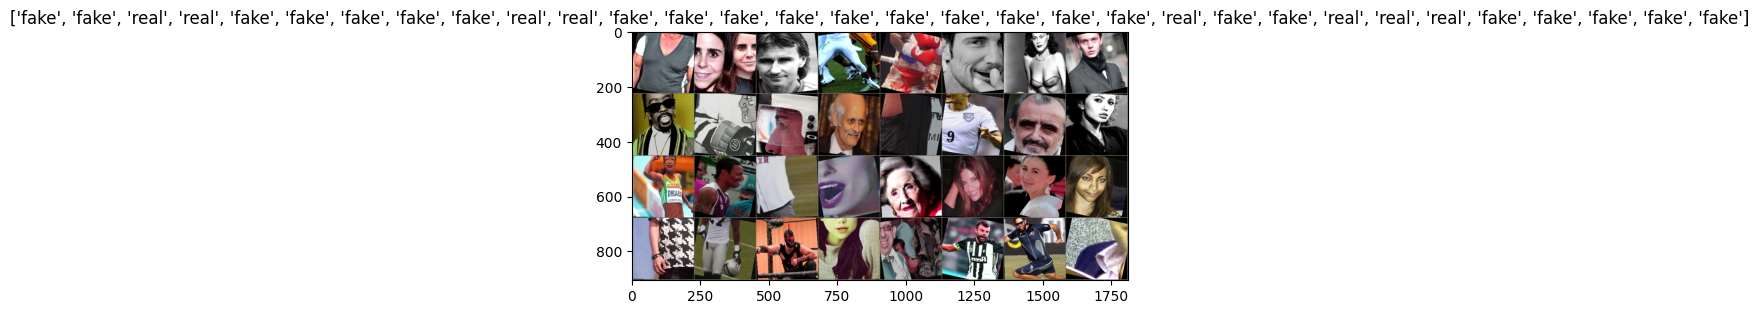

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(IMAGENET_MEAN)
    std = np.array(IMAGENET_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(default_dataloader["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the Model

This function trains a deep learning model using supervised learning with PyTorch. Key steps:

- Alternates between training (updating weights) and validation (evaluating performance).
- Uses cross-entropy loss and optimizes with gradient descent.
- Tracks the best validation accuracy, saving model parameters for later use.
- Implements a learning rate scheduler for better convergence.

After training, the model is restored to its best-performing state.

In [10]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, verbose=True):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

        torch.save(model.state_dict(), best_model_params_path)
        best_f1 = 0.0

        # Store loss, accuracy and f1 values
        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": [], 
                  "train_f1": [], "val_f1": []}

        for epoch in range(num_epochs):
            if verbose:
                print(f"Epoch {epoch + 1}/{num_epochs}")
                print("-" * 10)

            # Each epoch has a training and validation phase
            for phase in ["train", "val"]:
                if phase == "train":
                    model.train()  # Set model to training mode
                else:
                    model.eval()  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0
                all_preds = []
                all_labels = []
                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == "train"):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == "train":
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    # Collect predictions and labels for F1 score
                    all_preds.extend(preds.tolist())
                    all_labels.extend(labels.tolist())

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                if phase == "val" and scheduler is not None:
                    if type(scheduler) is lr_scheduler.ReduceLROnPlateau:
                        scheduler.step(epoch_loss)  # plateau based on validation loss
                    else:
                        scheduler.step()

                # Convert lists to numpy arrays for sklearn
                all_preds = np.array(all_preds)
                all_labels = np.array(all_labels)

                # Calculate F1 score (using weighted average due to class imbalance)
                epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

                # Store metrics in history
                history[f"{phase}_loss"].append(epoch_loss)
                history[f"{phase}_acc"].append(epoch_acc.item())
                history[f"{phase}_f1"].append(epoch_f1)

                if verbose:
                    print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}")

                # deep copy the model (using F1 score as the criterion for best model)
                if phase == "val" and epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    torch.save(model.state_dict(), best_model_params_path)

            if verbose:
                print()

        time_elapsed = time.time() - since
        print(
            f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s"
        )
        if verbose:
            print(f"Best val F1: {best_f1:4f}")

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model, history

## Evaluating Model Predictions

This function visualizes the model’s predictions on validation data:

- The model switches to evaluation mode to disable weight updates.
- Images and predicted labels are displayed alongside ground truth data.
- Helps assess model performance qualitatively by identifying correct and incorrect classifications.

This provides an intuitive check on how well the model generalizes to unseen data.

In [162]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(default_dataloader["val"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f"predicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Defining and Optimizing the Model

In this step, we initialize a ResNet-18 model pre-trained on ImageNet (IMAGENET1K_V1) and adapt it for our binary classification task (real vs. fake images). The final fully connected (fc) layer is replaced with a new linear layer that outputs two classes.

We define:
- Loss Function: CrossEntropyLoss, commonly used for classification tasks.
- Optimizer: Stochastic Gradient Descent (SGD) with momentum (0.9) to improve convergence.
- Learning Rate Scheduler: The learning rate decays by a factor of 0.1 every 7 epochs to enhance model stability during training.

In [29]:
model_base = models.resnet18()
model_base.fc = nn.Linear(model_base.fc.in_features, 2)

model_base = model_base.to(device)

criterion = nn.CrossEntropyLoss()

# All parameters are being optimized
optimizer_base = optim.SGD(model_base.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_base, step_size=7, gamma=0.1)

In [30]:
model_base, epoch_results_base = train_model(
    model_base, dataloaders["no_augmentation"]["resnet"], criterion, optimizer_base, exp_lr_scheduler, num_epochs=15
)

Epoch 1/15
----------
train Loss: 0.5234 Acc: 0.7503 F1: 0.6870
val Loss: 0.4810 Acc: 0.7619 F1: 0.7089

Epoch 2/15
----------
train Loss: 0.4746 Acc: 0.7682 F1: 0.7388
val Loss: 0.4945 Acc: 0.7459 F1: 0.7572

Epoch 3/15
----------
train Loss: 0.4360 Acc: 0.7957 F1: 0.7802
val Loss: 0.5113 Acc: 0.7374 F1: 0.7496

Epoch 4/15
----------
train Loss: 0.3929 Acc: 0.8212 F1: 0.8118
val Loss: 0.4780 Acc: 0.7749 F1: 0.7841

Epoch 5/15
----------
train Loss: 0.3458 Acc: 0.8467 F1: 0.8405
val Loss: 0.6200 Acc: 0.7963 F1: 0.7689

Epoch 6/15
----------
train Loss: 0.3072 Acc: 0.8662 F1: 0.8619
val Loss: 0.8815 Acc: 0.7608 F1: 0.6690

Epoch 7/15
----------
train Loss: 0.2670 Acc: 0.8856 F1: 0.8827
val Loss: 0.2597 Acc: 0.8814 F1: 0.8856

Epoch 8/15
----------
train Loss: 0.1297 Acc: 0.9477 F1: 0.9471
val Loss: 0.1371 Acc: 0.9477 F1: 0.9459

Epoch 9/15
----------
train Loss: 0.0909 Acc: 0.9628 F1: 0.9625
val Loss: 0.1064 Acc: 0.9542 F1: 0.9547

Epoch 10/15
----------
train Loss: 0.0749 Acc: 0.9690 F

## Training the Model

Now, we train our fine-tuned ResNet-18 model using the previously defined optimizer, loss function, and learning rate scheduler. The model will adjust its weights based on our dataset.

Note: In the original tutorial, the model is trained for 25 epochs, but since we are using more images than the tutorial and training on a CPU, I set it to just 1 epoch to keep runtime around 12 minutes.

## Feature Extraction with ResNet-18

Instead of fine-tuning all ResNet-18 layers, we freeze the pre-trained weights (requires_grad = False) and only train the final fully connected layer for binary classification. This approach, known as feature extraction, is useful when we have a smaller dataset and want to leverage pre-trained features.

- Only the final layer is optimized, making training more efficient.
- We still use SGD with momentum and a learning rate scheduler to optimize training.

This method ensures we benefit from ResNet’s powerful pre-trained features while reducing the computational cost of training. 

In [31]:
model_feature_extraction = torchvision.models.resnet18(weights="IMAGENET1K_V1")
for param in model_feature_extraction.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
model_feature_extraction.fc = nn.Linear(model_feature_extraction.fc.in_features, 2)
model_feature_extraction = model_feature_extraction.to(device)

criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized
optimizer_feature_extraction = optim.SGD(model_feature_extraction.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_feature_extraction, step_size=7, gamma=0.1)

In [32]:
model_feature_extraction, epoch_results_feature_extraction = train_model(
    model_feature_extraction, dataloaders["no_augmentation"]["resnet"], criterion, optimizer_feature_extraction, exp_lr_scheduler, num_epochs=15
)

Epoch 1/15
----------
train Loss: 0.4727 Acc: 0.7809 F1: 0.7566
val Loss: 0.4491 Acc: 0.7909 F1: 0.7890

Epoch 2/15
----------
train Loss: 0.4525 Acc: 0.7919 F1: 0.7744
val Loss: 0.4344 Acc: 0.8046 F1: 0.7881

Epoch 3/15
----------
train Loss: 0.4501 Acc: 0.7940 F1: 0.7774
val Loss: 0.4320 Acc: 0.8003 F1: 0.7881

Epoch 4/15
----------
train Loss: 0.4504 Acc: 0.7940 F1: 0.7778
val Loss: 0.4324 Acc: 0.8053 F1: 0.7891

Epoch 5/15
----------
train Loss: 0.4468 Acc: 0.7943 F1: 0.7785
val Loss: 0.4457 Acc: 0.7918 F1: 0.7905

Epoch 6/15
----------
train Loss: 0.4483 Acc: 0.7944 F1: 0.7785
val Loss: 0.4364 Acc: 0.8027 F1: 0.7767

Epoch 7/15
----------
train Loss: 0.4463 Acc: 0.7952 F1: 0.7798
val Loss: 0.4355 Acc: 0.8047 F1: 0.7841

Epoch 8/15
----------
train Loss: 0.4308 Acc: 0.8032 F1: 0.7871
val Loss: 0.4298 Acc: 0.8047 F1: 0.7833

Epoch 9/15
----------
train Loss: 0.4293 Acc: 0.8059 F1: 0.7895
val Loss: 0.4270 Acc: 0.8064 F1: 0.7905

Epoch 10/15
----------
train Loss: 0.4306 Acc: 0.8037 F

In [98]:
model_resnet_no_augm_ft = models.resnet18(weights="IMAGENET1K_V1")
model_resnet_no_augm_ft.fc = nn.Linear(model_resnet_no_augm_ft.fc.in_features, 2)
model_resnet_no_augm_ft = model_resnet_no_augm_ft.to(device)

criterion = nn.CrossEntropyLoss()

# All parameters are being optimized
optimizer_ft = optim.SGD(model_resnet_no_augm_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [99]:
model_resnet_no_augm_ft, epoch_results_ft = train_model(
    model_resnet_no_augm_ft, dataloaders["no_augmentation"]["resnet"], criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 1/15
----------
train Loss: 0.2598 Acc: 0.8887 F1: 0.8862
val Loss: 0.0897 Acc: 0.9633 F1: 0.9636

Epoch 2/15
----------
train Loss: 0.0579 Acc: 0.9773 F1: 0.9773
val Loss: 0.0442 Acc: 0.9823 F1: 0.9823

Epoch 3/15
----------
train Loss: 0.0334 Acc: 0.9867 F1: 0.9867
val Loss: 0.0335 Acc: 0.9862 F1: 0.9862

Epoch 4/15
----------
train Loss: 0.0234 Acc: 0.9909 F1: 0.9909
val Loss: 0.0393 Acc: 0.9841 F1: 0.9842

Epoch 5/15
----------
train Loss: 0.0165 Acc: 0.9937 F1: 0.9937
val Loss: 0.0392 Acc: 0.9841 F1: 0.9842

Epoch 6/15
----------
train Loss: 0.0112 Acc: 0.9959 F1: 0.9959
val Loss: 0.0313 Acc: 0.9894 F1: 0.9894

Epoch 7/15
----------
train Loss: 0.0091 Acc: 0.9969 F1: 0.9969
val Loss: 0.0466 Acc: 0.9865 F1: 0.9864

Epoch 8/15
----------
train Loss: 0.0042 Acc: 0.9987 F1: 0.9987
val Loss: 0.0294 Acc: 0.9896 F1: 0.9896

Epoch 9/15
----------
train Loss: 0.0027 Acc: 0.9994 F1: 0.9994
val Loss: 0.0275 Acc: 0.9907 F1: 0.9907

Epoch 10/15
----------
train Loss: 0.0024 Acc: 0.9995 F

## Visualizing Model Predictions

This function allows us to visualize the model’s prediction for a given image. It follows these steps:

- Loads the image and applies the same transformations used during validation.
- Converts the image into a format suitable for the model (unsqueeze(0) to add batch dimension).
- Disables gradient computation (torch.no_grad()) for efficient inference.
- Predicts the class and displays the image with its predicted label.

This function helps us qualitatively evaluate the model’s performance by seeing its predictions on real examples.

In [169]:
def visualize_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = resnet_basic_transform(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2, 2, 1)
        ax.axis("off")
        ax.set_title(f"Predicted: {class_names[preds[0]]}")
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

## Running the Visualization on a Sample Image

Here, we test our trained feature extraction model (model_conv) by passing a real image from the validation set. The model's prediction is displayed alongside the image.

Note: Ensure that the input image is not grayscale. The function expects an RGB image (3 channels), and passing a single-channel grayscale image may lead to errors or unexpected behavior.

In [170]:
# visualize_model_predictions(
#     model_conv, img_path="resized_data/val/fake/50745_1941-10-13_2011.jpg"
# )

plt.ioff()
plt.show()

## Plotting Classification Performance

In [11]:
def plot_training_history(history, title_label=""):
    if title_label != "":
        title_label = f": {title_label}"
    epochs = range(len(history["train_loss"]))

    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.title(f"Training & Validation Loss{title_label}")
    plt.legend()

    # F1 Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_f1"], label="Train F1")
    plt.plot(epochs, history["val_f1"], label="Validation F1")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title(f"Training & Validation F1 Score{title_label}")
    plt.legend()


    plt.show()

In [20]:
def test_model(model, test_dataloader, verbose=True):
    """
    Evaluates the model on the test dataset and returns accuracy and F1 score.
    
    Args:
        model (torch.nn.Module): Trained PyTorch model.
    Returns:
        dict: A dictionary containing accuracy and F1 score.
    """
    model.eval()  # Set model to evaluation mode
    running_corrects = 0
    all_preds = []
    all_labels = []
    dataloader = test_dataloader

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    # Compute accuracy
    dataset_size = len(dataloader.dataset)
    accuracy = running_corrects.double() / dataset_size

    # Compute F1-score
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    f1 = f1_score(np.array(all_labels), np.array(all_preds), average='weighted')

    if verbose:
        print(f"Test Accuracy: {accuracy:.5f}, Test F1 Score: {f1:.5f}")

    return {"acc": accuracy.item(), "f1_score": f1, "labels": all_labels, "preds": all_preds}

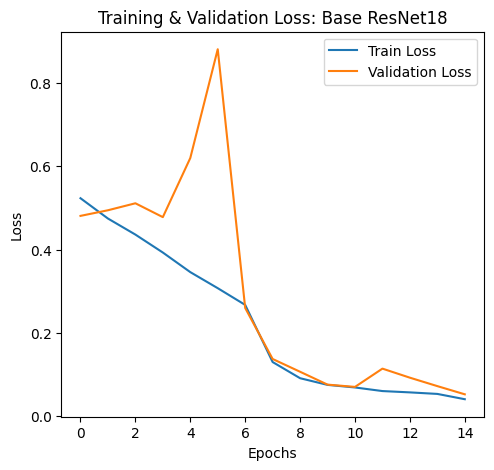

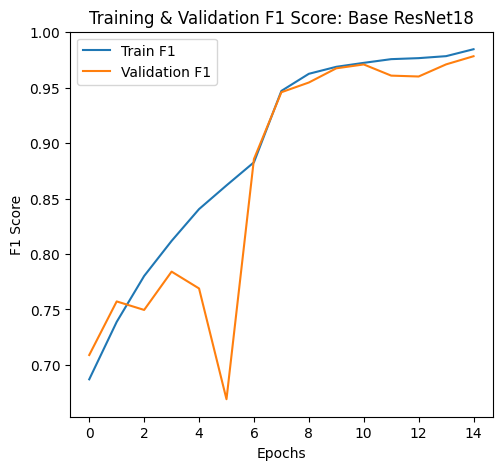

In [36]:
plot_training_history(epoch_results_base, "Base ResNet18")

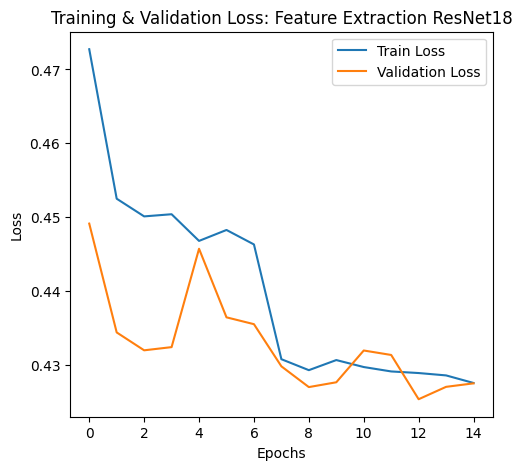

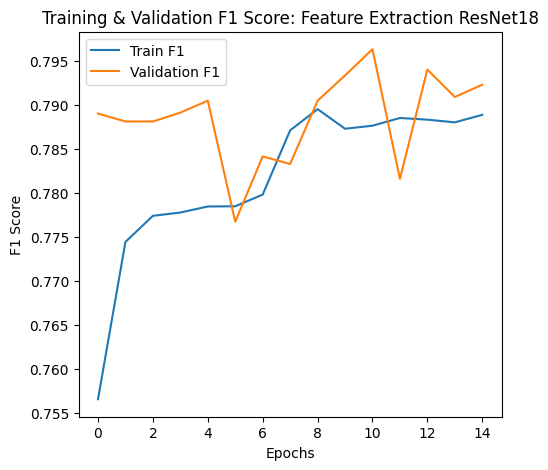

In [37]:
plot_training_history(epoch_results_feature_extraction, "Feature Extraction ResNet18")

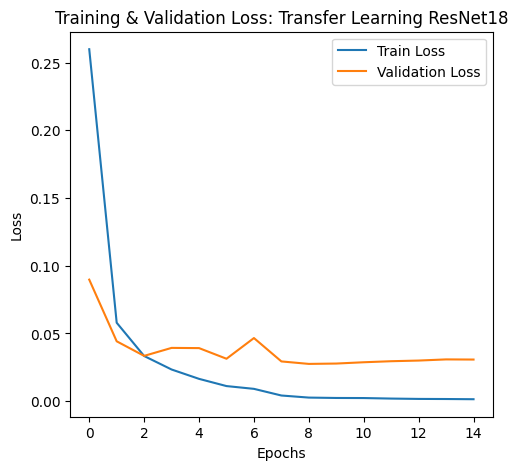

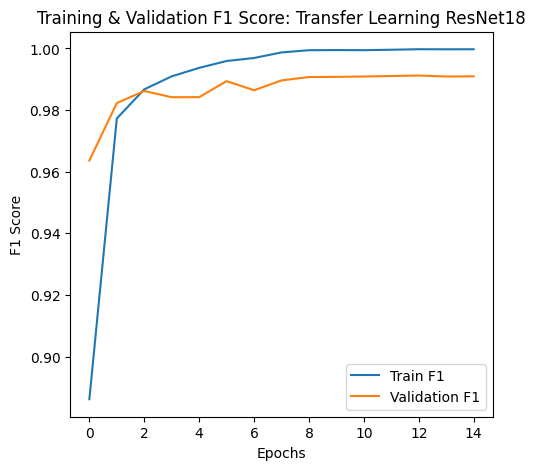

In [38]:
plot_training_history(epoch_results_ft, "Transfer Learning ResNet18")

In [39]:
model_ft_data_augmented = models.resnet18(weights="IMAGENET1K_V1")
model_ft_data_augmented.fc = nn.Linear(model_ft_data_augmented.fc.in_features, 2)
model_ft_data_augmented = model_ft_data_augmented.to(device)

criterion = nn.CrossEntropyLoss()

# All parameters are being optimized
optimizer_ft_augmented = optim.SGD(model_ft_data_augmented.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_augmented, step_size=7, gamma=0.1)

In [40]:
model_ft_augmented, epoch_results_ft_augmented = train_model(
    model_ft_data_augmented, dataloaders["augmentation"]["resnet"], criterion, optimizer_ft_augmented, exp_lr_scheduler, num_epochs=15
)

Epoch 1/15
----------
train Loss: 0.4173 Acc: 0.8099 F1: 0.7951
val Loss: 0.3008 Acc: 0.8676 F1: 0.8635

Epoch 2/15
----------
train Loss: 0.3502 Acc: 0.8444 F1: 0.8373
val Loss: 0.2827 Acc: 0.8836 F1: 0.8744

Epoch 3/15
----------
train Loss: 0.3216 Acc: 0.8564 F1: 0.8514
val Loss: 0.2333 Acc: 0.8994 F1: 0.8995

Epoch 4/15
----------
train Loss: 0.3015 Acc: 0.8664 F1: 0.8624
val Loss: 0.2454 Acc: 0.8943 F1: 0.8928

Epoch 5/15
----------
train Loss: 0.2886 Acc: 0.8725 F1: 0.8692
val Loss: 0.2297 Acc: 0.9011 F1: 0.9005

Epoch 6/15
----------
train Loss: 0.2743 Acc: 0.8796 F1: 0.8767
val Loss: 0.1894 Acc: 0.9192 F1: 0.9164

Epoch 7/15
----------
train Loss: 0.2664 Acc: 0.8830 F1: 0.8805
val Loss: 0.2104 Acc: 0.9095 F1: 0.9103

Epoch 8/15
----------
train Loss: 0.2347 Acc: 0.8977 F1: 0.8960
val Loss: 0.1626 Acc: 0.9312 F1: 0.9302

Epoch 9/15
----------
train Loss: 0.2284 Acc: 0.9006 F1: 0.8991
val Loss: 0.1605 Acc: 0.9321 F1: 0.9312

Epoch 10/15
----------
train Loss: 0.2240 Acc: 0.9024 F

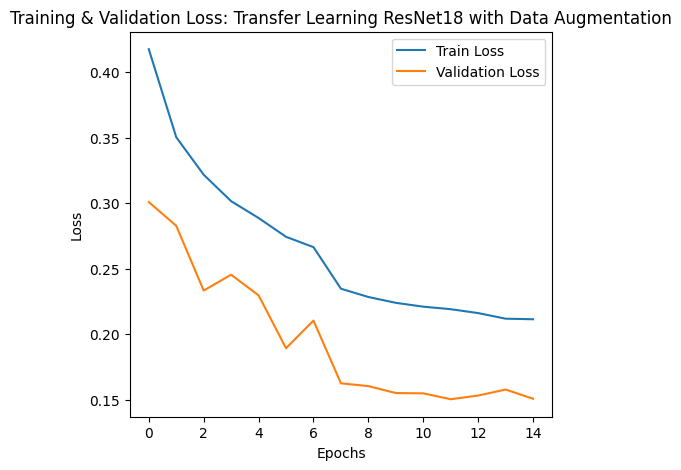

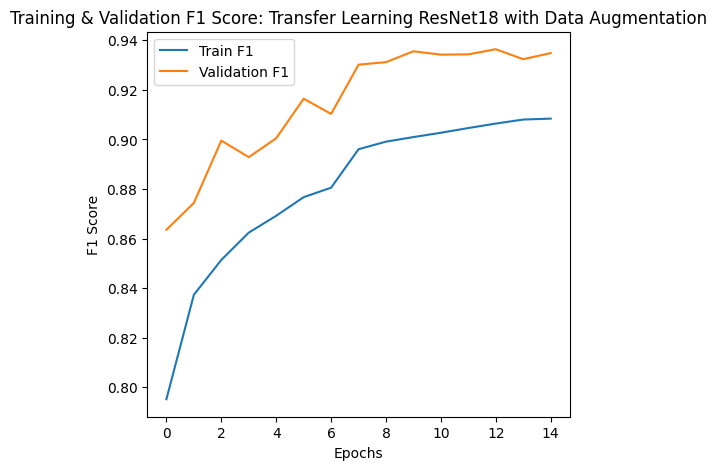

In [41]:
plot_training_history(epoch_results_ft_augmented, "Transfer Learning ResNet18 with Data Augmentation")

In [44]:
model_ft_data_augmented_v2 = models.resnet18(weights="IMAGENET1K_V1")
model_ft_data_augmented_v2.fc = nn.Linear(model_ft_data_augmented_v2.fc.in_features, 2)
model_ft_data_augmented_v2 = model_ft_data_augmented_v2.to(device)

criterion = nn.CrossEntropyLoss()

# All parameters are being optimized
optimizer_ft_augmented_v2 = optim.SGD(model_ft_data_augmented_v2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_augmented_v2, step_size=7, gamma=0.1)

In [45]:
model_ft_data_augmented_v2, epoch_results_ft_augmented_v2 = train_model(
    model_ft_data_augmented_v2, dataloaders["augmentation_v2"]["resnet"], criterion, optimizer_ft_augmented_v2, exp_lr_scheduler, num_epochs=15
)

Epoch 1/15
----------
train Loss: 0.4359 Acc: 0.7966 F1: 0.7804
val Loss: 0.3097 Acc: 0.8645 F1: 0.8629

Epoch 2/15
----------
train Loss: 0.3669 Acc: 0.8339 F1: 0.8261
val Loss: 0.2797 Acc: 0.8754 F1: 0.8758

Epoch 3/15
----------
train Loss: 0.3363 Acc: 0.8479 F1: 0.8422
val Loss: 0.2748 Acc: 0.8774 F1: 0.8805

Epoch 4/15
----------
train Loss: 0.3154 Acc: 0.8600 F1: 0.8557
val Loss: 0.2315 Acc: 0.8959 F1: 0.8969

Epoch 5/15
----------
train Loss: 0.3006 Acc: 0.8651 F1: 0.8614
val Loss: 0.2544 Acc: 0.8906 F1: 0.8831

Epoch 6/15
----------
train Loss: 0.2867 Acc: 0.8730 F1: 0.8700
val Loss: 0.2029 Acc: 0.9135 F1: 0.9121

Epoch 7/15
----------
train Loss: 0.2776 Acc: 0.8764 F1: 0.8739
val Loss: 0.1953 Acc: 0.9177 F1: 0.9185

Epoch 8/15
----------
train Loss: 0.2435 Acc: 0.8937 F1: 0.8919
val Loss: 0.1635 Acc: 0.9306 F1: 0.9304

Epoch 9/15
----------
train Loss: 0.2368 Acc: 0.8968 F1: 0.8952
val Loss: 0.1587 Acc: 0.9324 F1: 0.9321

Epoch 10/15
----------
train Loss: 0.2332 Acc: 0.8982 F

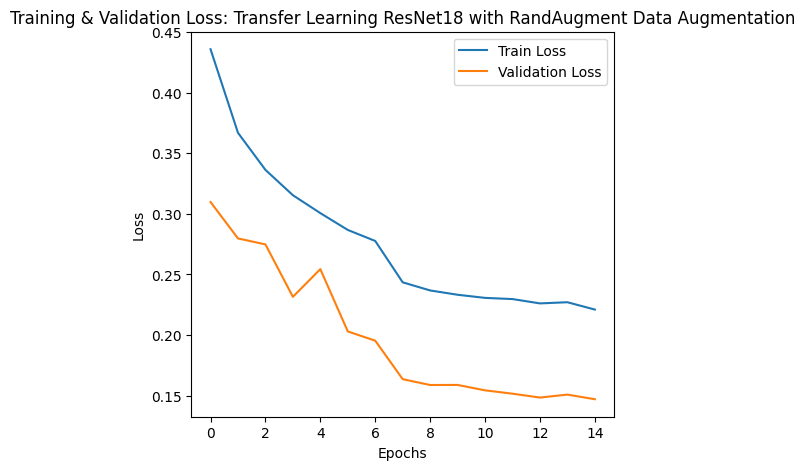

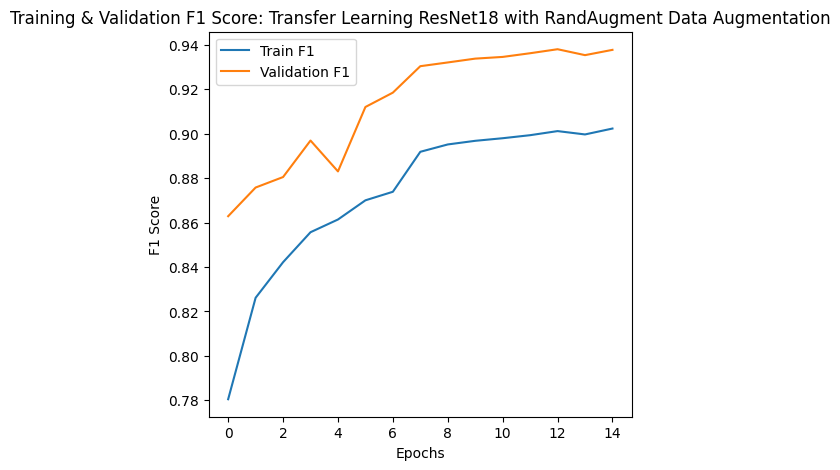

In [46]:
plot_training_history(epoch_results_ft_augmented_v2, "Transfer Learning ResNet18 with RandAugment Data Augmentation")

In [102]:
model_ft_data_augmented_weaker = models.resnet18(weights="IMAGENET1K_V1")
model_ft_data_augmented_weaker.fc = nn.Linear(model_ft_data_augmented_weaker.fc.in_features, 2)
model_ft_data_augmented_weaker = model_ft_data_augmented_weaker.to(device)

criterion = nn.CrossEntropyLoss()

# All parameters are being optimized
optimizer_ft_augmented_weaker = optim.SGD(model_ft_data_augmented_weaker.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_augmented_weaker, step_size=7, gamma=0.1)

In [103]:
model_ft_data_augmented_weaker, epoch_results_ft_augmented_weaker = train_model(
    model_ft_data_augmented_weaker,
    dataloaders["augmentation_weaker"]["resnet"], criterion, optimizer_ft_augmented_weaker, exp_lr_scheduler, num_epochs=15
)

Epoch 1/15
----------
train Loss: 0.3253 Acc: 0.8526 F1: 0.8476
val Loss: 0.1975 Acc: 0.9141 F1: 0.9149

Epoch 2/15
----------
train Loss: 0.2225 Acc: 0.9034 F1: 0.9027
val Loss: 0.3502 Acc: 0.8481 F1: 0.8566

Epoch 3/15
----------
train Loss: 0.1888 Acc: 0.9190 F1: 0.9187
val Loss: 0.1582 Acc: 0.9326 F1: 0.9337

Epoch 4/15
----------
train Loss: 0.1687 Acc: 0.9290 F1: 0.9288
val Loss: 0.1540 Acc: 0.9336 F1: 0.9346

Epoch 5/15
----------
train Loss: 0.1533 Acc: 0.9348 F1: 0.9348
val Loss: 0.1388 Acc: 0.9420 F1: 0.9413

Epoch 6/15
----------
train Loss: 0.1431 Acc: 0.9402 F1: 0.9402
val Loss: 0.1239 Acc: 0.9457 F1: 0.9461

Epoch 7/15
----------
train Loss: 0.1322 Acc: 0.9450 F1: 0.9450
val Loss: 0.1375 Acc: 0.9413 F1: 0.9414

Epoch 8/15
----------
train Loss: 0.1010 Acc: 0.9596 F1: 0.9596
val Loss: 0.1000 Acc: 0.9587 F1: 0.9585

Epoch 9/15
----------
train Loss: 0.0948 Acc: 0.9618 F1: 0.9618
val Loss: 0.0967 Acc: 0.9610 F1: 0.9610

Epoch 10/15
----------
train Loss: 0.0905 Acc: 0.9632 F

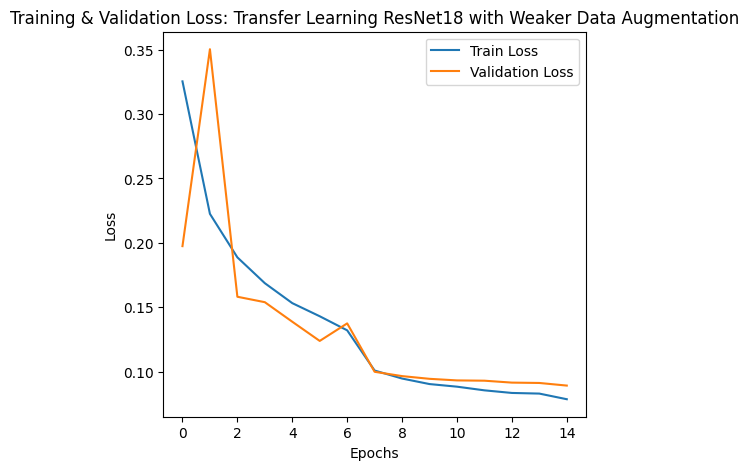

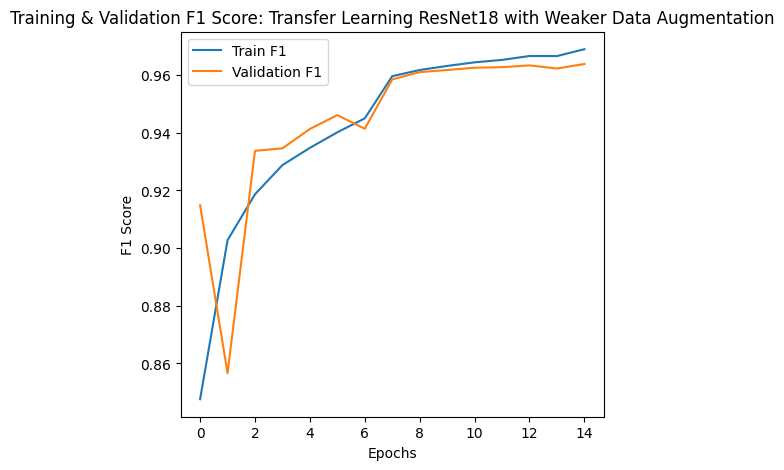

In [104]:
plot_training_history(epoch_results_ft_augmented_weaker, "Transfer Learning ResNet18 with Weaker Data Augmentation")

In [162]:
model_ft_data_augmented_no_crop = models.resnet18(weights="IMAGENET1K_V1")
model_ft_data_augmented_no_crop.fc = nn.Linear(model_ft_data_augmented_no_crop.fc.in_features, 2)
model_ft_data_augmented_no_crop = model_ft_data_augmented_no_crop.to(device)

criterion = nn.CrossEntropyLoss()

# All parameters are being optimized
optimizer_ft_augmented_no_crop = optim.SGD(model_ft_data_augmented_no_crop.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft_augmented_no_crop, step_size=7, gamma=0.1)

In [163]:
model_ft_data_augmented_no_crop, epoch_results_ft_augmented_no_crop = train_model(
    model_ft_data_augmented_no_crop,
    dataloaders["augmentation_no_crop"]["resnet"], criterion, optimizer_ft_augmented_no_crop, exp_lr_scheduler, num_epochs=15
)

Epoch 1/15
----------
train Loss: 0.3007 Acc: 0.8694 F1: 0.8656
val Loss: 0.2684 Acc: 0.8916 F1: 0.8825

Epoch 2/15
----------
train Loss: 0.2024 Acc: 0.9148 F1: 0.9140
val Loss: 0.1753 Acc: 0.9258 F1: 0.9265

Epoch 3/15
----------
train Loss: 0.1685 Acc: 0.9294 F1: 0.9290
val Loss: 0.1423 Acc: 0.9407 F1: 0.9407

Epoch 4/15
----------
train Loss: 0.1472 Acc: 0.9394 F1: 0.9392
val Loss: 0.1493 Acc: 0.9348 F1: 0.9357

Epoch 5/15
----------
train Loss: 0.1311 Acc: 0.9455 F1: 0.9454
val Loss: 0.1973 Acc: 0.9190 F1: 0.9204

Epoch 6/15
----------
train Loss: 0.1172 Acc: 0.9527 F1: 0.9527
val Loss: 0.1257 Acc: 0.9484 F1: 0.9482

Epoch 7/15
----------
train Loss: 0.1056 Acc: 0.9566 F1: 0.9565
val Loss: 0.1210 Acc: 0.9508 F1: 0.9506

Epoch 8/15
----------
train Loss: 0.0775 Acc: 0.9691 F1: 0.9690
val Loss: 0.1004 Acc: 0.9591 F1: 0.9591

Epoch 9/15
----------
train Loss: 0.0715 Acc: 0.9715 F1: 0.9715
val Loss: 0.0988 Acc: 0.9602 F1: 0.9602

Epoch 10/15
----------
train Loss: 0.0682 Acc: 0.9727 F

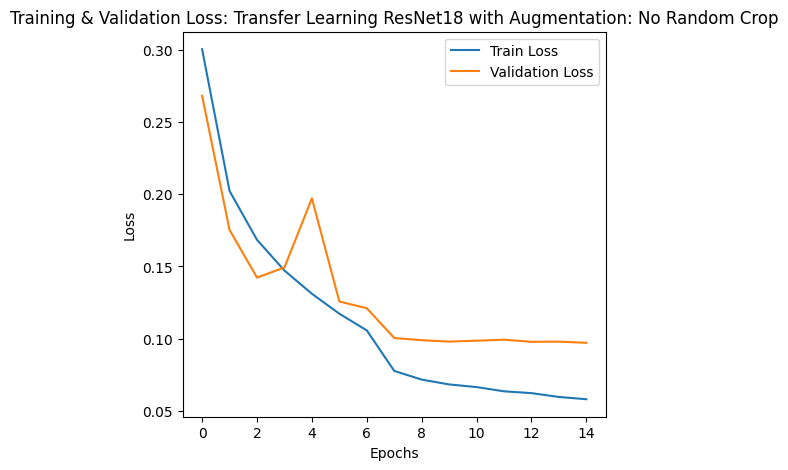

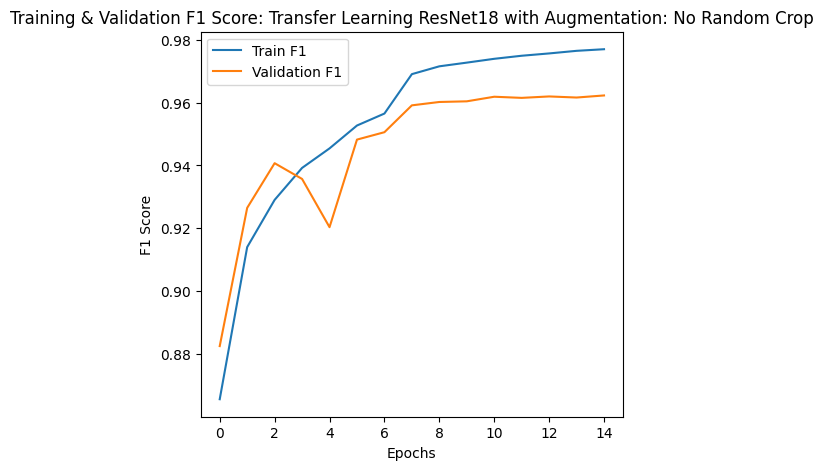

In [164]:
plot_training_history(epoch_results_ft_augmented_no_crop, "Transfer Learning ResNet18 with Augmentation: No Random Crop")

#### Improve learning rate decay and attempt to reduce training instability
- Use Adam optimizer
- Use different learning rates
- Use a different learning rate scheduler

In [13]:
def get_plot_location(filename):
    """Get the file path for saving a plot."""
    return os.path.join("plots", filename)

In [14]:
def add_value_labels(bars, values, decimal_places=3, fontsize=10, rotation=0, y_offset=0.01):
    """
    Add value labels to bars in a bar plot.
    
    Args:
        bars: Bar container from plt.bar()
        values: Values to display
        decimal_places: Number of decimal places to show
        fontsize: Size of label text
        rotation: Rotation angle for text
        y_offset: Vertical offset from top of bar
    """
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + y_offset,
                f'{values[i]:.{decimal_places}f}',
                ha='center', va='bottom', rotation=rotation, fontsize=fontsize)

def create_group_averages(results, key):
    """
    Group results by a specific key and calculate average and max F1 scores.
    
    Args:
        results: List of result dictionaries
        key: The key to group by (e.g., 'optimizer', 'criterion')
        
    Returns:
        groups, group_names, avg_f1, max_f1
    """
    groups = {}
    for r in results:
        if r[key] not in groups:
            groups[r[key]] = []
        groups[r[key]].append(r['val_f1'])
    
    group_names = list(groups.keys())
    avg_f1 = [np.mean(groups[name]) for name in group_names]
    max_f1 = [np.max(groups[name]) for name in group_names]
    
    return groups, group_names, avg_f1, max_f1

def plot_comparison_bars(group_names, avg_values, max_values, x_label, title, filename):
    """
    Create a comparison bar plot with two bars per group.
    
    Args:
        group_names: Names of the groups (x-axis labels)
        avg_values: Average values for each group
        max_values: Maximum values for each group
        x_label: Label for the x-axis
        title: Plot title
        filename: Filename for saving the plot
    """
    plt.figure(figsize=(12, 6))
    
    x = np.arange(len(group_names))
    width = 0.35
    
    avg_bars = plt.bar(x - width/2, avg_values, width, label='Average F1')
    max_bars = plt.bar(x + width/2, max_values, width, label='Best F1')
    
    # Add value labels
    add_value_labels(avg_bars, avg_values)
    add_value_labels(max_bars, max_values)
    
    plt.xticks(x, group_names)
    plt.xlabel(x_label)
    plt.ylabel('F1 Score')
    plt.title(title)
    plt.legend()
    plt.savefig(filename)
    plt.show()

def plot_ranked_configurations(sorted_results, model_name):
    """Plot all configurations ranked by validation F1 score."""
    plt.figure(figsize=(14, 8))

    configs = [f"{r['dataloader']}, {r['criterion']}\n{r['optimizer']}, {r['lr']}, {r['scheduler']}" for r in sorted_results]
    f1_scores = [r['val_f1'] for r in sorted_results]

    bars = plt.bar(range(len(configs)), f1_scores)

    # Color the best configuration differently
    bars[0].set_color('green')
    
    # Add value labels with smaller font size and rotation
    if len(configs) > 10:
        # Many bars - use smaller font and rotated text
        add_value_labels(bars, f1_scores, fontsize=8, rotation=0, y_offset=0.005)
    else:
        # Fewer bars - standard formatting
        add_value_labels(bars, f1_scores)

    plt.xticks(range(len(configs)), configs, rotation=90, ha='right')
    plt.xlabel('Hyperparameter Configuration')
    plt.ylabel('Best Validation F1 Score')
    plt.title('Hyperparameter Configurations Ranked by F1 Score')
    plt.tight_layout()
    
    # Adjust top margin to accommodate rotated labels
    plt.subplots_adjust(top=0.9)
    
    plt.savefig(get_plot_location(f'hyperparameter_rankings_{model_name}.png'))
    plt.show()

def plot_learning_curves(sorted_results, model_name):
    """Plot learning curves for the top 3 models."""
    plt.figure(figsize=(16, 12))

    for i, result in enumerate(sorted_results[:min(3, len(sorted_results))]):
        config_name = f"{result['criterion']} + {result['optimizer']} + {result['lr']} + {result['scheduler']} + {result['dataloader']}"

        plt.subplot(3, 2, i*2+1)
        plt.plot(result['history']['train_loss'], label='Train Loss')
        plt.plot(result['history']['val_loss'], label='Validation Loss')
        plt.title(f"Top {i+1}: {config_name} - Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(3, 2, i*2+2)
        plt.plot(result['history']['train_f1'], label='Train F1')
        plt.plot(result['history']['val_f1'], label='Validation F1')
        plt.title(f"Top {i+1}: {config_name} - F1 Score")
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()

    plt.tight_layout()
    plt.savefig(get_plot_location(f'top_model_learning_curves_{model_name}.png'))
    plt.show()

def plot_hyperparameter_results(results, model_name):
    """
    Plot the results of hyperparameter tuning
    
    Args:
        results: List of result dictionaries from hyperparameter tuning
        model_name: Name of the model for file naming
    """
    # Sort results by validation F1 score
    sorted_results = sorted(results, key=lambda x: x['val_f1'], reverse=True)

    # 1. Bar plot comparing all configurations by F1 score
    plot_ranked_configurations(sorted_results, model_name)

    # 2. Learning curves of top 3 models
    plot_learning_curves(sorted_results, model_name)

    # 3. Optimizer comparison
    _, optimizers, avg_f1, max_f1 = create_group_averages(results, 'optimizer')
    plot_comparison_bars(
        optimizers, avg_f1, max_f1,
        'Optimizer', 'Optimizer Performance Comparison',
        get_plot_location(f'optimizer_comparison_{model_name}.png')
    )

    # 4. Criterion comparison
    _, criterions, avg_f1, max_f1 = create_group_averages(results, 'criterion')
    plot_comparison_bars(
        criterions, avg_f1, max_f1,
        'Loss Function', 'Loss Function Performance Comparison',
        get_plot_location(f'criterion_comparison_{model_name}.png')
    )
    
    # 5. Scheduler comparison
    _, schedulers, avg_f1, max_f1 = create_group_averages(results, 'scheduler')
    plot_comparison_bars(
        schedulers, avg_f1, max_f1,
        'Scheduler', 'Scheduler Performance Comparison',
        get_plot_location(f'scheduler_comparison_{model_name}.png')
    )
    
    # 6. Dataloader comparison
    _, dataloaders, avg_f1, max_f1 = create_group_averages(results, 'dataloader')
    plot_comparison_bars(
        dataloaders, avg_f1, max_f1,
        'Dataloader', 'Dataloader Performance Comparison',
        get_plot_location(f'dataloader_comparison_{model_name}.png')
    )

## Hyperparameter Tuning
We use data augmentation here, as opposed to before on the simple training examples. The performance is much better with data augmentation, so we decided not to tune without it (just a waste of computational resources).

In [15]:
def hyperparameter_tuning(get_model, dataloader, dataloader_label, num_epochs):
    """Tune hyperparameters and return the best model."""
    criterion_options = {
        "CE": nn.CrossEntropyLoss(),
        "Weighted CE": nn.CrossEntropyLoss(weight=class_weights.to(device)),
    }
    optimizer_options = {
        "sgd":
            lambda params, lr: optim.SGD(params, lr=lr, momentum=0.9),
        "adam":
            lambda params, lr: optim.Adam(params, lr=lr, betas=(0.9, 0.999)),
    }
    scheduler_options = {
        "step_lr":
            lambda opt: lr_scheduler.StepLR(opt, step_size=7, gamma=0.1),
        "plateau_lr":
            lambda opt: lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=7),
    }
    learning_rate = [0.001, 0.0001]

    # Generate all combinations
    param_combinations = []
    for criterion_name, criterion in criterion_options.items():
        for opt_name, opt_fn in optimizer_options.items():
            for sched_name, sched_fn in scheduler_options.items():
                for lr in learning_rate:
                    param_combinations.append({
                        'lr': lr,
                        'criterion_name': criterion_name,
                        'criterion': criterion,
                        'opt_name': opt_name,
                        'opt_fn': opt_fn,
                        'sched_name': sched_name,
                        'sched_fn': sched_fn,
                    })
    print(f"Total combinations to try: {len(param_combinations)}")

    best_f1 = 0.0
    best_model = None
    best_params = None
    histories = []
    results = []

    for i, params in enumerate(param_combinations):
        # Extract parameters
        criterion_name = params['criterion_name']
        criterion = params['criterion']
        opt_name = params['opt_name']
        opt_fn = params['opt_fn']
        sched_name = params['sched_name']
        sched_fn = params['sched_fn']
        lr = params['lr']

        # Initialize fresh model
        model, model_params = get_model()
        optimizer = opt_fn(model_params, lr)
        scheduler = sched_fn(optimizer) if sched_fn else None

        print(f"\nTrial {i+1}/{len(param_combinations)}")
        print(f"Criterion: {criterion_name}")
        print(f"Optimizer: {opt_name}")
        print(f"Scheduler: {sched_name}")

        # Train and evaluate
        trained_model, history = train_model(
            model,
            dataloader,
            criterion,
            optimizer,
            scheduler,
            num_epochs=num_epochs,
            verbose=False,
        )

        val_f1 = max(history["val_f1"])  # Best validation F1 from this run
        histories.append(history)

        # Save results for plotting
        results.append({
            'lr': lr,
            'criterion': criterion_name,
            'optimizer': opt_name,
            'scheduler': sched_name,
            'val_f1': val_f1,
            'trial': i+1,
            'history': history,
            'dataloader': dataloader_label,
        })

        # Track best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model = trained_model
            best_params = {
                'lr': lr,
                'criterion': criterion_name, 
                'optimizer': opt_name, 
                'scheduler': sched_name,
                'dataloader': dataloader_label,
            }

        print(f"Trial {i+1} Best Val F1: {val_f1:.4f}")

    print("\nBest Hyperparameters:")
    print(f"Criterion: {best_params['criterion']}")
    print(f"Optimizer: {best_params['optimizer']}")
    print(f"Scheduler: {best_params['scheduler']}")
    print(f"Dataloader: {dataloader_label}")
    print(f"Best Learning Rate: {best_params['lr']}")
    print(f"Best Validation F1: {best_f1:.4f}")

    return best_model, best_params, best_f1, results

## Models to tune
- Using ResNet without pretraining, as well as using it with pure Feature extraction from pretraining, performs much worse so it was excluded from hyperparameter tuning
- The other models we experimented with are too heavy for this kind of automatic tuning. For these models, we simply manually changed a few parameters

In [16]:
def get_fully_trainable_resnet():
    model = models.resnet18(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(model.fc.in_features, 2)
    model = model.to(device)
    return model, model.parameters()

hyperparam_tuning_models = {
    "Fully Trainable ResNet18": get_fully_trainable_resnet,
}
hyperparam_tuning_dataloaders = {
    "Fully Trainable ResNet18": [
        ("no_augm", dataloaders["no_augmentation"]["resnet"]),
        ("weak_augm", dataloaders["augmentation_weaker"]["resnet"]),
    ]
}

In [17]:
plot_results = defaultdict(list)
final_model = None
final_model_val_f1 = 0.0
final_model_params = None
for model_name, model in hyperparam_tuning_models.items():
    print("\n")
    print(model_name)
    for dataloader_label, dataloader in hyperparam_tuning_dataloaders[model_name]:
        print(f"- Using dataloader: {dataloader_label}")
        best_model, best_params, best_f1, tuning_results = hyperparameter_tuning(model, dataloader, dataloader_label, num_epochs=20)
        if best_f1 > final_model_val_f1:
            final_model = best_model
            final_model_val_f1 = best_f1
            final_model_params = best_params
        plot_results[model_name].extend(tuning_results)

    print(f"Finished {model_name}")



Fully Trainable ResNet18
- Using dataloader: no_augm
Total combinations to try: 16

Trial 1/16
Criterion: CE
Optimizer: sgd
Scheduler: step_lr
Training complete in 36m 5s
Trial 1 Best Val F1: 0.9917

Trial 2/16
Criterion: CE
Optimizer: sgd
Scheduler: step_lr
Training complete in 36m 11s
Trial 2 Best Val F1: 0.9486

Trial 3/16
Criterion: CE
Optimizer: sgd
Scheduler: plateau_lr
Training complete in 36m 13s
Trial 3 Best Val F1: 0.9915

Trial 4/16
Criterion: CE
Optimizer: sgd
Scheduler: plateau_lr
Training complete in 36m 5s
Trial 4 Best Val F1: 0.9856

Trial 5/16
Criterion: CE
Optimizer: adam
Scheduler: step_lr
Training complete in 37m 10s
Trial 5 Best Val F1: 0.9938

Trial 6/16
Criterion: CE
Optimizer: adam
Scheduler: step_lr
Training complete in 37m 11s
Trial 6 Best Val F1: 0.9944

Trial 7/16
Criterion: CE
Optimizer: adam
Scheduler: plateau_lr
Training complete in 37m 12s
Trial 7 Best Val F1: 0.9917

Trial 8/16
Criterion: CE
Optimizer: adam
Scheduler: plateau_lr
Training complete in 3

In [18]:
# Results path (save or load for plotting)
os.makedirs("results", exist_ok=True)

def get_hyperparam_results_path(model_name):
    return os.path.join("results", f"hyperparameter_tuning_results_{model_name}.csv")

In [19]:
# Save results to CSV
for model_name, model_results in plot_results.items():
    df = pd.DataFrame(model_results)

    df['history'] = df['history'].apply(json.dumps) # Convert history to JSON string for saving
    model_results_path = get_hyperparam_results_path(model_name)

    df.to_csv(model_results_path, index=False)

In [20]:
# Save best model from hyperparam tuning
best_model_resnet18_path = os.path.join("models", "best_resnet18.pth")
torch.save(final_model.state_dict(), best_model_resnet18_path)

In [21]:
# Load resutls from CSV
hyperparam_results = {}
for model_name in hyperparam_tuning_models.keys():
    results_path = get_hyperparam_results_path("Fully Trainable ResNet18")

    model_results = pd.read_csv(results_path, index_col=None)
    model_results['history'] = model_results['history'].apply(json.loads)   # Convert history JSON string back to dictionary

    hyperparam_results[model_name] = model_results.to_dict('records')

Fully Trainable ResNet18


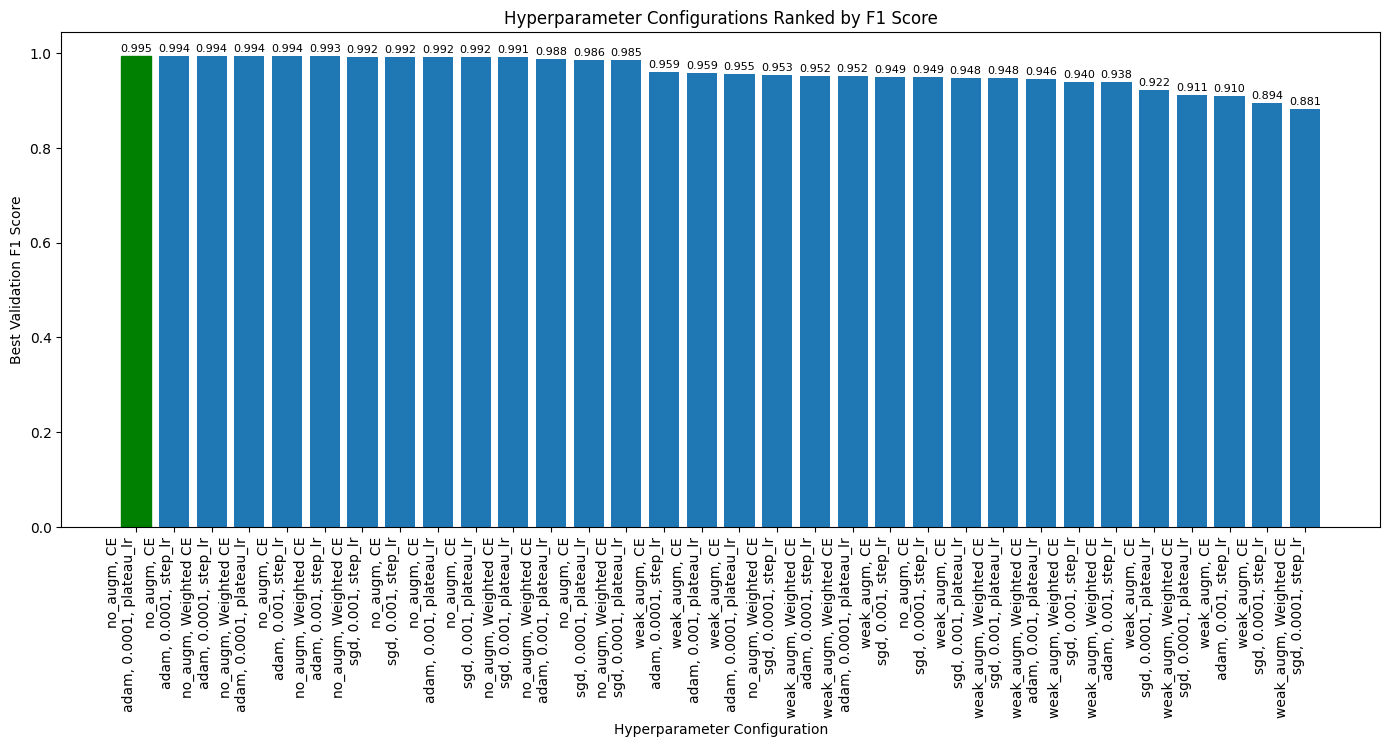

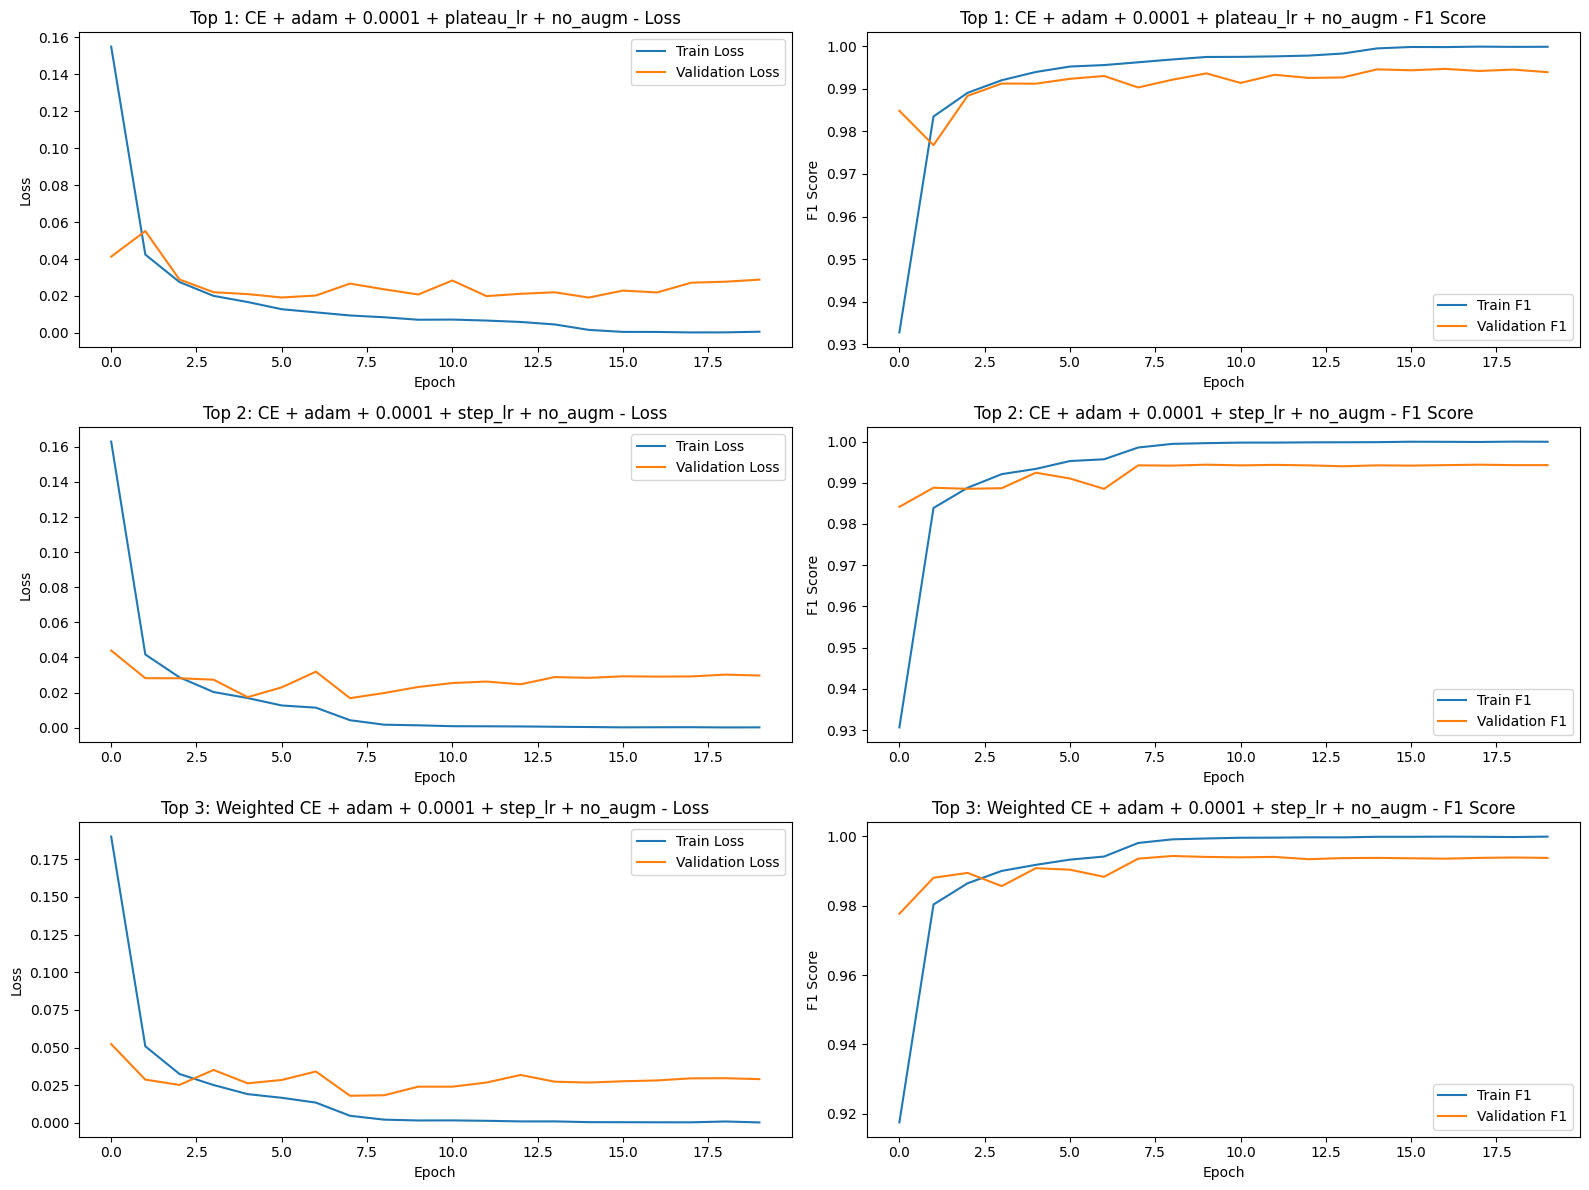

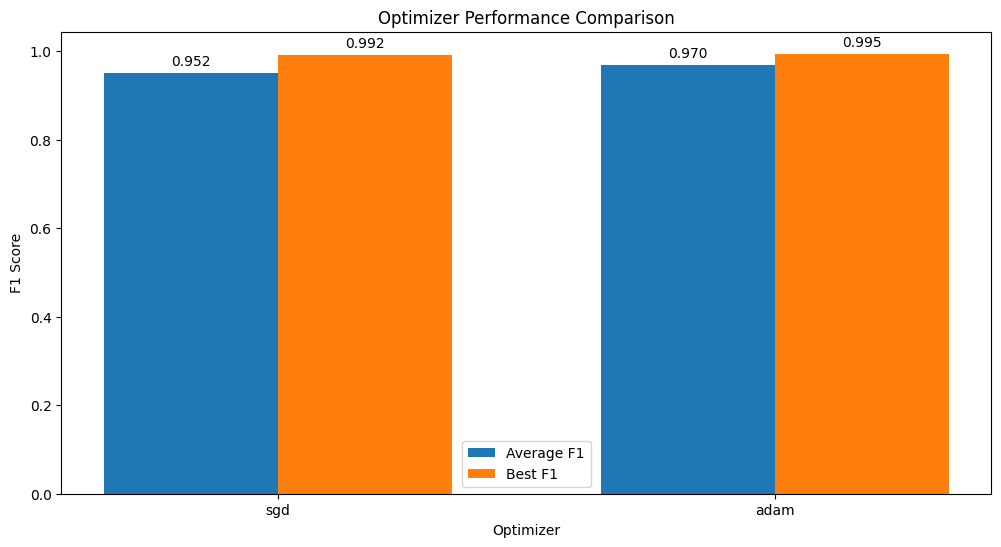

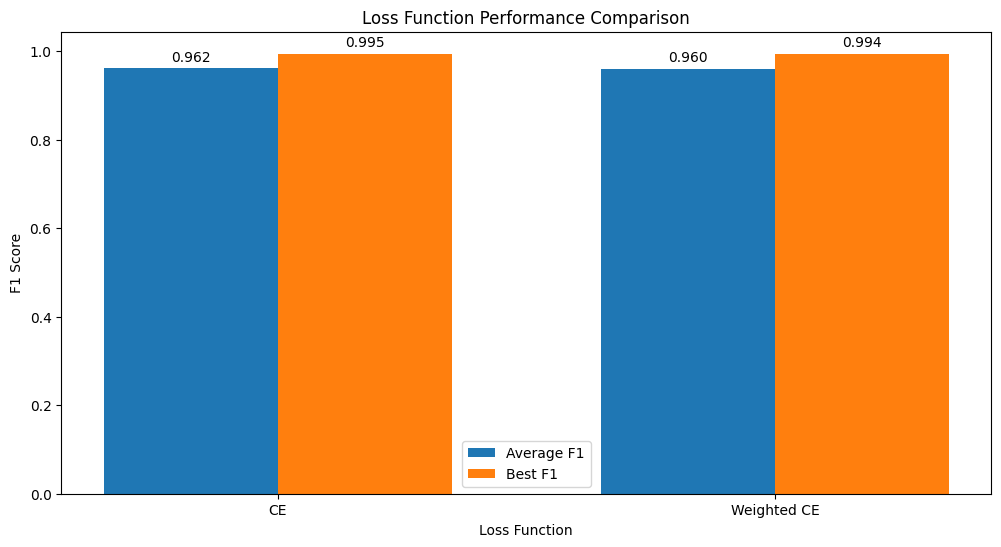

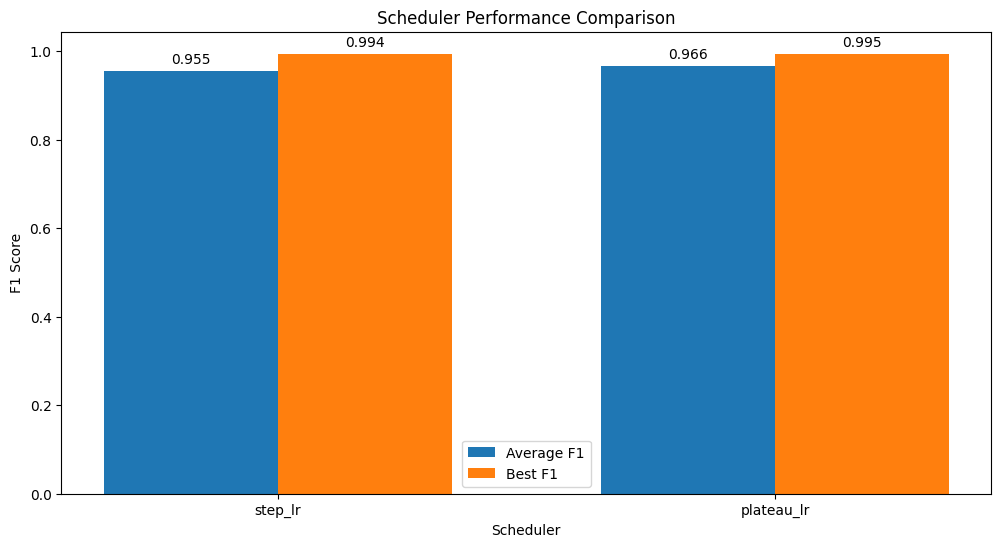

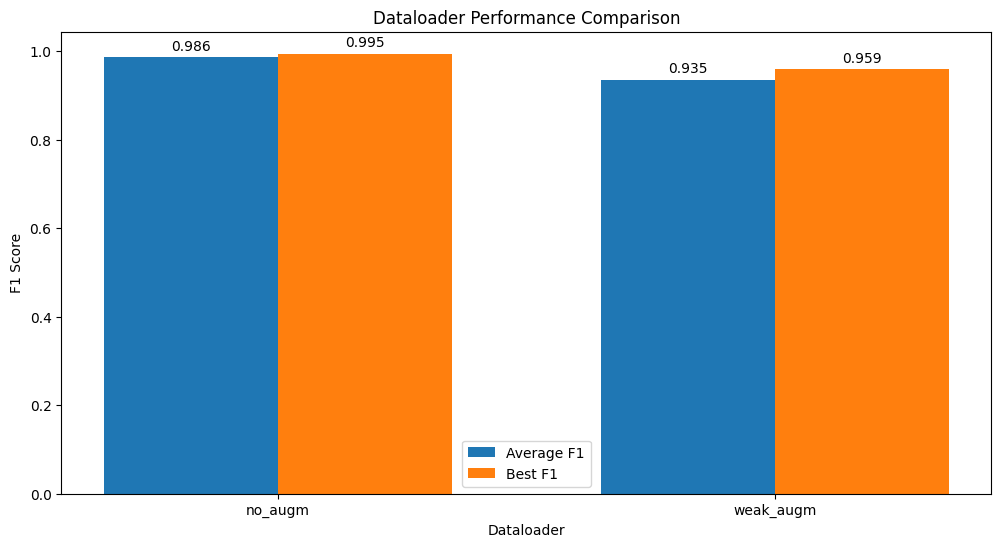

In [22]:
# Plot the results
for model_name, results in hyperparam_results.items():
    print(model_name)
    plot_hyperparameter_results(results, model_name)

In [23]:
test_results = test_model(final_model, dataloaders["no_augmentation"]["resnet"]["test"])
print(f"Best Model: {final_model_params}")
print(f" - Best Validation F1: {final_model_val_f1:.4f}")
print(f" - Test Accuracy: {test_results['acc']:.4f}")
print(f" - Test F1 Score: {test_results['f1_score']:.4f}")

Test Accuracy: 0.9956, Test F1 Score: 0.9956
Best Model: {'lr': 0.0001, 'criterion': 'CE', 'optimizer': 'adam', 'scheduler': 'plateau_lr', 'dataloader': 'no_augm'}
 - Best Validation F1: 0.9947
 - Test Accuracy: 0.9956
 - Test F1 Score: 0.9956


In [ ]:
model_efficient_net_ft_no_augm = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)

num_ftrs = model_efficient_net_ft_no_augm.classifier[1].in_features
model_efficient_net_ft_no_augm.classifier[1] = nn.Linear(num_ftrs, 2)   # 2 output features (for binary classification)
model_efficient_net_ft = model_efficient_net_ft_no_augm.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_efficient_net_ft = optim.Adam(model_efficient_net_ft_no_augm.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_efficient_net_ft, step_size=7, gamma=0.1)

In [17]:
model_efficient_net_ft_no_augm, epoch_results_efficient_net_no_augm = train_model(
    model_efficient_net_ft_no_augm, dataloaders["no_augmentation"]["efficient_net"], criterion, optimizer_efficient_net_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 1/15
----------
train Loss: 0.0514 Acc: 0.9800 F1: 0.9800
val Loss: 0.0166 Acc: 0.9943 F1: 0.9944

Epoch 2/15
----------
train Loss: 0.0110 Acc: 0.9964 F1: 0.9964
val Loss: 0.0017 Acc: 0.9996 F1: 0.9996

Epoch 3/15
----------
train Loss: 0.0057 Acc: 0.9982 F1: 0.9982
val Loss: 0.0038 Acc: 0.9989 F1: 0.9989

Epoch 4/15
----------
train Loss: 0.0035 Acc: 0.9990 F1: 0.9990
val Loss: 0.0024 Acc: 0.9986 F1: 0.9986

Epoch 5/15
----------
train Loss: 0.0028 Acc: 0.9991 F1: 0.9991
val Loss: 0.0033 Acc: 0.9992 F1: 0.9992

Epoch 6/15
----------
train Loss: 0.0021 Acc: 0.9994 F1: 0.9994
val Loss: 0.0017 Acc: 0.9994 F1: 0.9994

Epoch 7/15
----------
train Loss: 0.0017 Acc: 0.9995 F1: 0.9995
val Loss: 0.0017 Acc: 0.9995 F1: 0.9995

Epoch 8/15
----------
train Loss: 0.0007 Acc: 0.9998 F1: 0.9998
val Loss: 0.0012 Acc: 0.9997 F1: 0.9997

Epoch 9/15
----------
train Loss: 0.0003 Acc: 0.9999 F1: 0.9999
val Loss: 0.0011 Acc: 0.9997 F1: 0.9997

Epoch 10/15
----------
train Loss: 0.0002 Acc: 1.0000 F

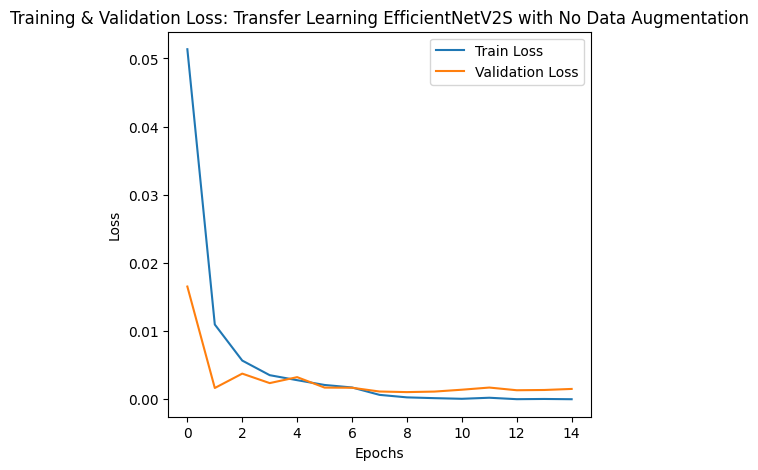

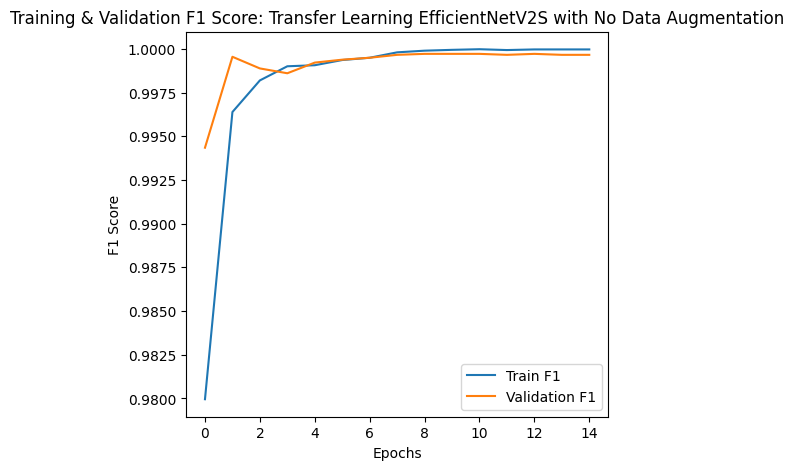

In [18]:
plot_training_history(epoch_results_efficient_net_no_augm, "Transfer Learning EfficientNetV2S with No Data Augmentation")

In [ ]:
model_efficient_net_ft = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)

num_ftrs = model_efficient_net_ft.classifier[1].in_features
model_efficient_net_ft.classifier[1] = nn.Linear(num_ftrs, 2)   # 2 output features (for binary classification)
model_efficient_net_ft = model_efficient_net_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_efficient_net_ft = optim.Adam(model_efficient_net_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_efficient_net_ft, step_size=7, gamma=0.1)

In [13]:
model_efficient_net_ft, epoch_results_efficient_net = train_model(
    model_efficient_net_ft, dataloaders["augmentation"]["efficient_net"], criterion, optimizer_efficient_net_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.2001 Acc: 0.9187 F1: 0.9178
val Loss: 0.0974 Acc: 0.9593 F1: 0.9586

Epoch 1/14
----------
train Loss: 0.1230 Acc: 0.9521 F1: 0.9520
val Loss: 0.0638 Acc: 0.9744 F1: 0.9743

Epoch 2/14
----------
train Loss: 0.1036 Acc: 0.9589 F1: 0.9588
val Loss: 0.0574 Acc: 0.9771 F1: 0.9770

Epoch 3/14
----------
train Loss: 0.0884 Acc: 0.9655 F1: 0.9654
val Loss: 0.0546 Acc: 0.9796 F1: 0.9796

Epoch 4/14
----------
train Loss: 0.0806 Acc: 0.9691 F1: 0.9690
val Loss: 0.0519 Acc: 0.9795 F1: 0.9795

Epoch 5/14
----------
train Loss: 0.0749 Acc: 0.9709 F1: 0.9708
val Loss: 0.0512 Acc: 0.9792 F1: 0.9792

Epoch 6/14
----------
train Loss: 0.0699 Acc: 0.9741 F1: 0.9740
val Loss: 0.0354 Acc: 0.9852 F1: 0.9852

Epoch 7/14
----------
train Loss: 0.0465 Acc: 0.9823 F1: 0.9822
val Loss: 0.0286 Acc: 0.9881 F1: 0.9881

Epoch 8/14
----------
train Loss: 0.0390 Acc: 0.9850 F1: 0.9849
val Loss: 0.0282 Acc: 0.9881 F1: 0.9881

Epoch 9/14
----------
train Loss: 0.0363 Acc: 0.9865 F1

In [35]:
model_efficient_net_ft_v2 = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)

num_ftrs = model_efficient_net_ft_v2.classifier[1].in_features
model_efficient_net_ft_v2.classifier[1] = nn.Linear(num_ftrs, 2)
model_efficient_net_ft_v2 = model_efficient_net_ft_v2.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_efficient_net_ft_v2 = optim.Adam(model_efficient_net_ft_v2.parameters(), lr=0.0001)
plateau_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_efficient_net_ft_v2, mode='min', factor=0.1, patience=7)

In [36]:
model_efficient_net_ft_v2, epoch_results_efficient_net_v2 = train_model(
    model_efficient_net_ft_v2, dataloaders["augmentation"]["efficient_net"], criterion, optimizer_efficient_net_ft_v2, plateau_lr_scheduler, num_epochs=25
)

Epoch 1/25
----------
train Loss: 0.1999 Acc: 0.9186 F1: 0.9177
val Loss: 0.1551 Acc: 0.9380 F1: 0.9391

Epoch 2/25
----------
train Loss: 0.1210 Acc: 0.9520 F1: 0.9519
val Loss: 0.0758 Acc: 0.9701 F1: 0.9703

Epoch 3/25
----------
train Loss: 0.1016 Acc: 0.9607 F1: 0.9606
val Loss: 0.0617 Acc: 0.9778 F1: 0.9779

Epoch 4/25
----------
train Loss: 0.0876 Acc: 0.9662 F1: 0.9661
val Loss: 0.0602 Acc: 0.9772 F1: 0.9772

Epoch 5/25
----------
train Loss: 0.0789 Acc: 0.9699 F1: 0.9698
val Loss: 0.0571 Acc: 0.9786 F1: 0.9784

Epoch 6/25
----------
train Loss: 0.0745 Acc: 0.9713 F1: 0.9712
val Loss: 0.0505 Acc: 0.9799 F1: 0.9800

Epoch 7/25
----------
train Loss: 0.0704 Acc: 0.9727 F1: 0.9726
val Loss: 0.0430 Acc: 0.9829 F1: 0.9828

Epoch 8/25
----------
train Loss: 0.0651 Acc: 0.9752 F1: 0.9751
val Loss: 0.0344 Acc: 0.9865 F1: 0.9864

Epoch 9/25
----------
train Loss: 0.0617 Acc: 0.9769 F1: 0.9768
val Loss: 0.0426 Acc: 0.9835 F1: 0.9834

Epoch 10/25
----------
train Loss: 0.0609 Acc: 0.9766 F

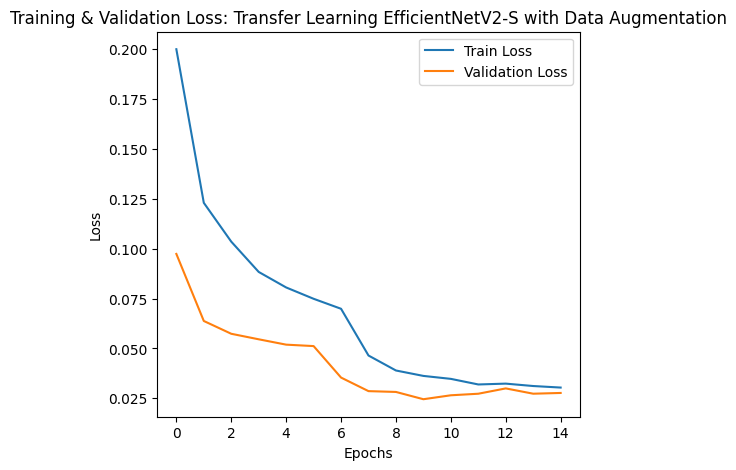

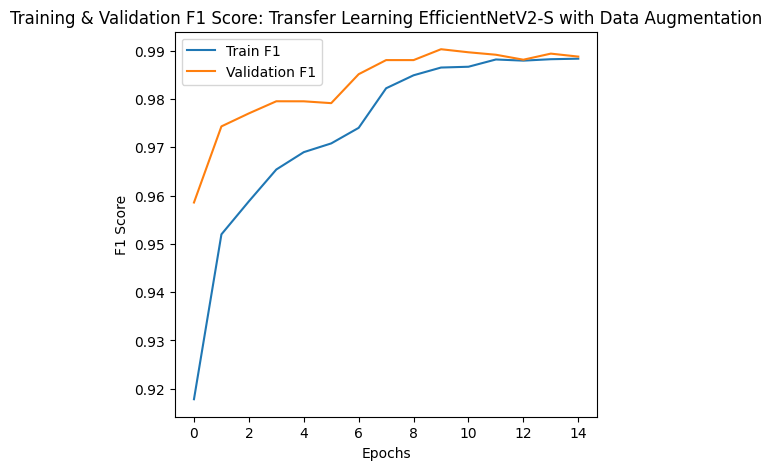

In [16]:
plot_training_history(epoch_results_efficient_net, "Transfer Learning EfficientNetV2-S with Data Augmentation")

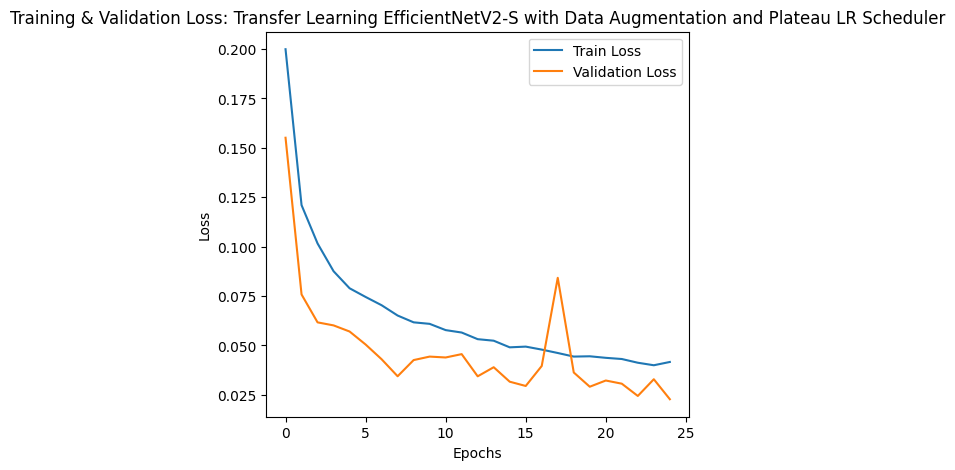

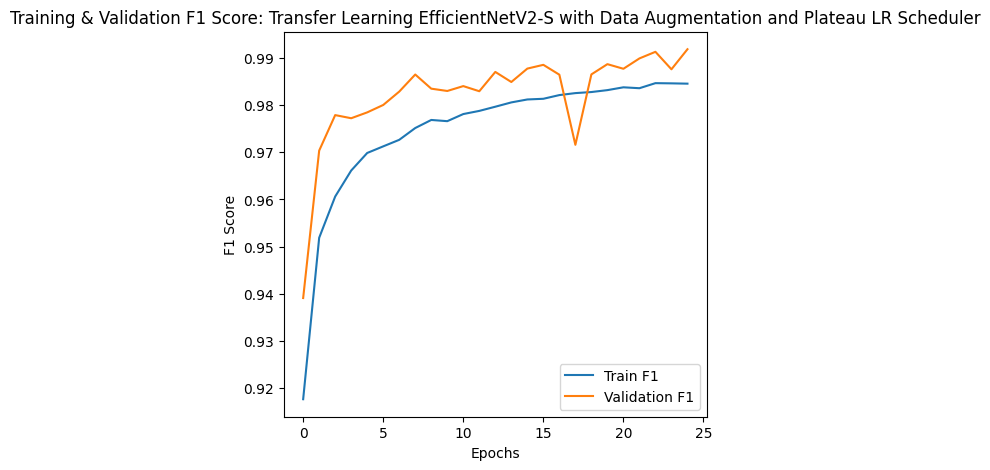

In [37]:
plot_training_history(epoch_results_efficient_net_v2, "Transfer Learning EfficientNetV2-S with Data Augmentation and Plateau LR Scheduler")

In [19]:
model_vit_ft_no_augm = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

num_ftrs = model_vit_ft_no_augm.heads.head.in_features
model_vit_ft_no_augm.heads.head = nn.Linear(num_ftrs, 2)
model_vit_ft_no_augm = model_vit_ft_no_augm.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_vit_ft = optim.Adam(model_vit_ft_no_augm.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vit_ft, step_size=7, gamma=0.1)

In [20]:
model_vit_ft_no_augm, epoch_results_vit_ft_no_augm = train_model(
    model_vit_ft_no_augm, dataloaders["no_augmentation"]["vit"], criterion, optimizer_vit_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 1/15
----------
train Loss: 0.3184 Acc: 0.8573 F1: 0.8514
val Loss: 0.2127 Acc: 0.9074 F1: 0.9048

Epoch 2/15
----------
train Loss: 0.1953 Acc: 0.9172 F1: 0.9162
val Loss: 0.2137 Acc: 0.9032 F1: 0.8966

Epoch 3/15
----------
train Loss: 0.1406 Acc: 0.9412 F1: 0.9408
val Loss: 0.1922 Acc: 0.9277 F1: 0.9260

Epoch 4/15
----------
train Loss: 0.1078 Acc: 0.9567 F1: 0.9566
val Loss: 0.1690 Acc: 0.9257 F1: 0.9235

Epoch 5/15
----------
train Loss: 0.0879 Acc: 0.9648 F1: 0.9647
val Loss: 0.1265 Acc: 0.9478 F1: 0.9469

Epoch 6/15
----------
train Loss: 0.0739 Acc: 0.9706 F1: 0.9706
val Loss: 0.1250 Acc: 0.9495 F1: 0.9494

Epoch 7/15
----------
train Loss: 0.0612 Acc: 0.9760 F1: 0.9760
val Loss: 0.1083 Acc: 0.9588 F1: 0.9588

Epoch 8/15
----------
train Loss: 0.0124 Acc: 0.9953 F1: 0.9953
val Loss: 0.1036 Acc: 0.9705 F1: 0.9703

Epoch 9/15
----------
train Loss: 0.0034 Acc: 0.9990 F1: 0.9990
val Loss: 0.1290 Acc: 0.9711 F1: 0.9709

Epoch 10/15
----------
train Loss: 0.0029 Acc: 0.9991 F

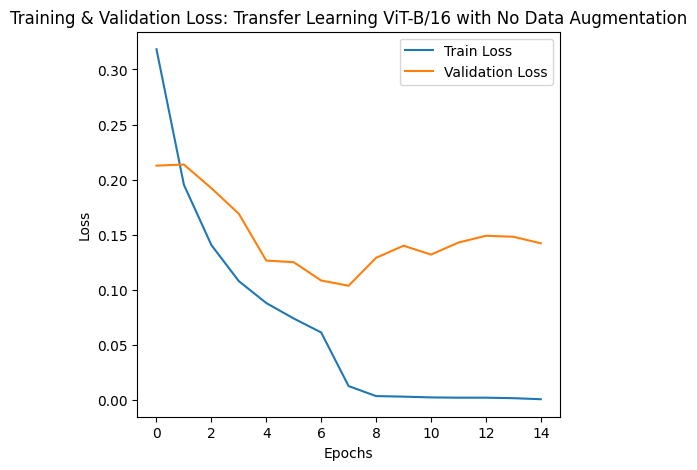

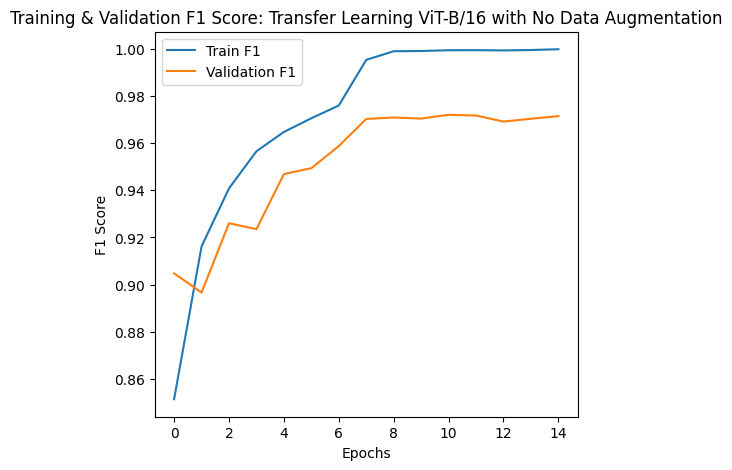

In [21]:
plot_training_history(epoch_results_vit_ft_no_augm, "Transfer Learning ViT-B/16 with No Data Augmentation")

In [ ]:
model_vit_ft = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

num_ftrs = model_vit_ft.heads.head.in_features
model_vit_ft.heads.head = nn.Linear(num_ftrs, 2)
model_vit_ft = model_vit_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_vit_ft = optim.Adam(model_vit_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_vit_ft, step_size=7, gamma=0.1)

In [12]:
model_vit_ft, epoch_results_vit_ft = train_model(
    model_vit_ft, dataloaders["augmentation"]["vit"], criterion, optimizer_vit_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.4395 Acc: 0.7928 F1: 0.7680
val Loss: 0.4310 Acc: 0.8066 F1: 0.8153

Epoch 1/14
----------
train Loss: 0.3682 Acc: 0.8295 F1: 0.8184
val Loss: 0.3414 Acc: 0.8481 F1: 0.8405

Epoch 2/14
----------
train Loss: 0.3432 Acc: 0.8426 F1: 0.8342
val Loss: 0.3119 Acc: 0.8541 F1: 0.8399

Epoch 3/14
----------
train Loss: 0.3214 Acc: 0.8540 F1: 0.8478
val Loss: 0.2753 Acc: 0.8709 F1: 0.8585

Epoch 4/14
----------
train Loss: 0.3089 Acc: 0.8600 F1: 0.8542
val Loss: 0.2774 Acc: 0.8767 F1: 0.8749

Epoch 5/14
----------
train Loss: 0.2926 Acc: 0.8684 F1: 0.8638
val Loss: 0.2525 Acc: 0.8899 F1: 0.8924

Epoch 6/14
----------
train Loss: 0.2806 Acc: 0.8750 F1: 0.8712
val Loss: 0.2325 Acc: 0.8964 F1: 0.8953

Epoch 7/14
----------
train Loss: 0.2056 Acc: 0.9105 F1: 0.9093
val Loss: 0.1609 Acc: 0.9312 F1: 0.9307

Epoch 8/14
----------
train Loss: 0.1826 Acc: 0.9224 F1: 0.9215
val Loss: 0.1596 Acc: 0.9319 F1: 0.9320

Epoch 9/14
----------
train Loss: 0.1678 Acc: 0.9274 F1

In [38]:
model_vit_ft_v2 = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

num_ftrs = model_vit_ft_v2.heads.head.in_features
model_vit_ft_v2.heads.head = nn.Linear(num_ftrs, 2)
model_vit_ft_v2 = model_vit_ft_v2.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_vit_ft_v2 = optim.Adam(model_vit_ft_v2.parameters(), lr=0.0001)
plateau_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_vit_ft_v2, mode='min', factor=0.1, patience=7)

In [39]:
model_vit_ft_v2, epoch_results_vit_ft_v2 = train_model(
    model_vit_ft_v2, dataloaders["augmentation"]["vit"], criterion, optimizer_vit_ft_v2, plateau_lr_scheduler, num_epochs=25
)

Epoch 1/25
----------
train Loss: 0.4489 Acc: 0.7863 F1: 0.7577
val Loss: 0.3677 Acc: 0.8297 F1: 0.8102

Epoch 2/25
----------
train Loss: 0.3753 Acc: 0.8255 F1: 0.8136
val Loss: 0.3302 Acc: 0.8477 F1: 0.8415

Epoch 3/25
----------
train Loss: 0.3420 Acc: 0.8429 F1: 0.8350
val Loss: 0.3012 Acc: 0.8608 F1: 0.8555

Epoch 4/25
----------
train Loss: 0.3228 Acc: 0.8524 F1: 0.8459
val Loss: 0.2466 Acc: 0.8918 F1: 0.8885

Epoch 5/25
----------
train Loss: 0.3081 Acc: 0.8601 F1: 0.8544
val Loss: 0.2646 Acc: 0.8834 F1: 0.8803

Epoch 6/25
----------
train Loss: 0.2934 Acc: 0.8672 F1: 0.8625
val Loss: 0.2631 Acc: 0.8864 F1: 0.8849

Epoch 7/25
----------
train Loss: 0.2841 Acc: 0.8720 F1: 0.8680
val Loss: 0.2677 Acc: 0.8760 F1: 0.8774

Epoch 8/25
----------
train Loss: 0.2719 Acc: 0.8787 F1: 0.8752
val Loss: 0.2182 Acc: 0.9024 F1: 0.8996

Epoch 9/25
----------
train Loss: 0.2595 Acc: 0.8855 F1: 0.8827
val Loss: 0.2634 Acc: 0.8848 F1: 0.8770

Epoch 10/25
----------
train Loss: 0.2524 Acc: 0.8885 F

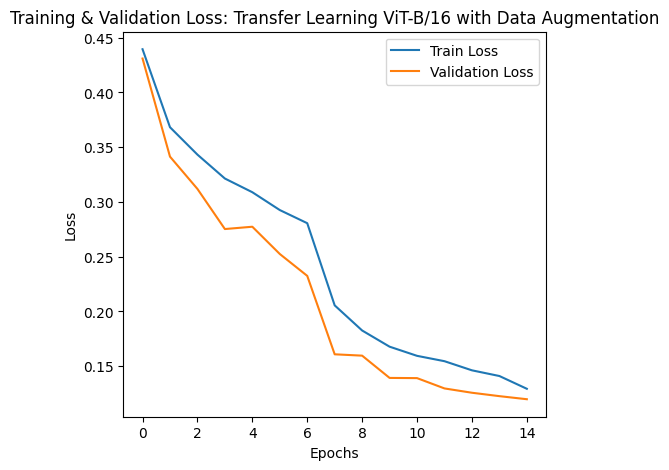

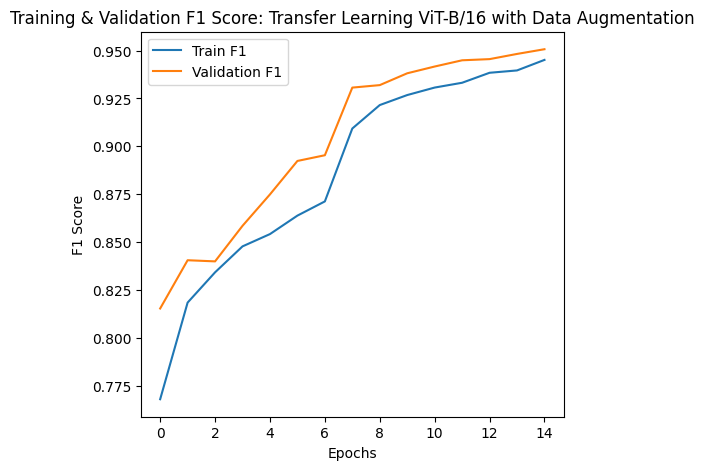

In [15]:
plot_training_history(epoch_results_vit_ft, "Transfer Learning ViT-B/16 with Data Augmentation")

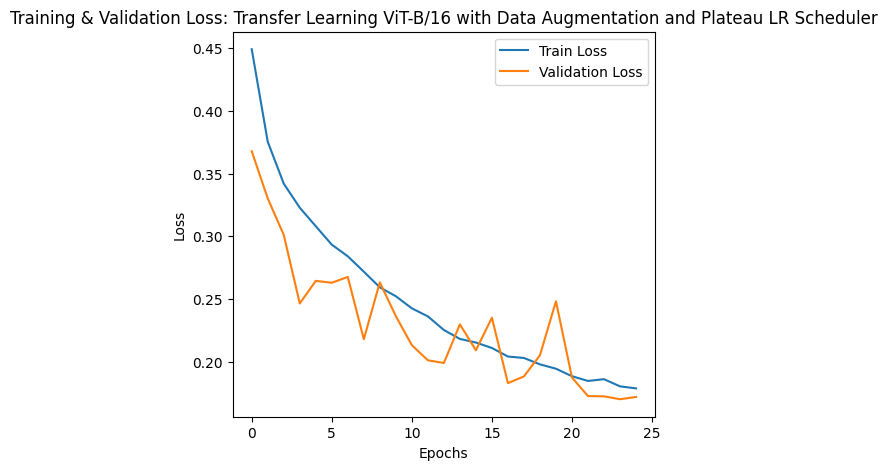

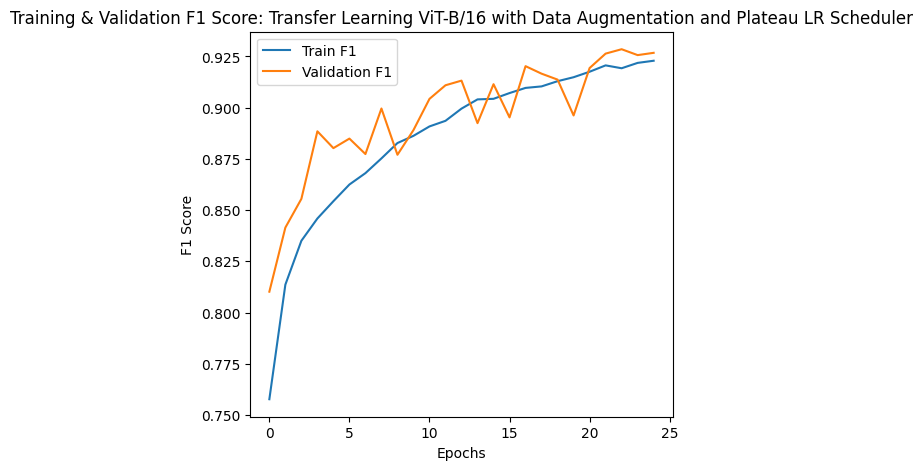

In [40]:
plot_training_history(epoch_results_vit_ft_v2, "Transfer Learning ViT-B/16 with Data Augmentation and Plateau LR Scheduler")

In [ ]:
# Get best model path (to save or load)
model_save_name = 'best_model_efficient_net.pth'
best_model_path = os.path.join("models", model_save_name)
best_model_info_path = os.path.join("models", "best_model_efficient_net_metadata.json")

In [24]:
best_model = model_efficient_net_ft_no_augm
best_model_info = {
    'model': 'efficientnet_v2_s',
    'val_f1': max(epoch_results_efficient_net_no_augm['val_f1']),
}
# Save best model parameters
torch.save(best_model.state_dict(), best_model_path)

with open(best_model_info_path, "w") as f:
    json.dump(best_model_info, f, indent=4)

In [ ]:
best_model = models.efficientnet_v2_s()
best_model.classifier[1] = nn.Linear(best_model.classifier[1].in_features, 2)

# Load best model
checkpoint = torch.load(best_model_path)
best_model.load_state_dict(checkpoint)
print("Loaded best model from disk")

with open(best_model_info_path, "r") as f:
    best_model_info = json.load(f)

print(f"Best model: {best_model_info['model']}")
print(f"Best validation F1: {best_model_info['val_f1']}")

Loaded best model from disk
Best model: efficientnet_v2_s
Best validation F1: 0.999722253069278


In [26]:
best_model = best_model.to(device)

In [28]:
results = test_model(best_model, dataloaders["no_augmentation"]["efficient_net"]["test"])

Test Accuracy: 0.9998, Test F1 Score: 0.9998


In [29]:
test_labels = results["labels"]
test_preds = results["preds"]
conf_matrix = confusion_matrix(test_labels, test_preds)

print(classification_report(test_labels, test_preds, target_names=class_names))
print(conf_matrix)

              precision    recall  f1-score   support

        fake       1.00      1.00      1.00     13500
        real       1.00      1.00      1.00      4500

    accuracy                           1.00     18000
   macro avg       1.00      1.00      1.00     18000
weighted avg       1.00      1.00      1.00     18000

[[13499     1]
 [    3  4497]]


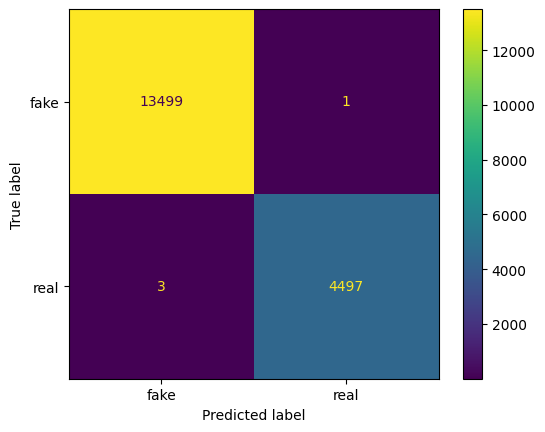

In [30]:
ConfusionMatrixDisplay(conf_matrix, display_labels=class_names).plot()
plt.show()

In [31]:
def show_errors(model, dataloader, class_mapping, num_examples, nrows, ncols):
    assert(nrows * ncols == num_examples)

    model.eval()  # Set model to evaluation mode
    errors = []

    for batch_idx, (X, y) in enumerate(dataloader):
        if len(errors) >= num_examples:
            break
        with torch.no_grad():
            inputs, labels = X.to(device), y.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        # Find the indices where predictions don't match labels
        incorrect_indices = (preds != labels).nonzero(as_tuple=True)[0]

        # Save images where predictions were wrong
        for i in incorrect_indices:
            if len(errors) >= num_examples:
                break
            errors.append((X[i].cpu(), labels[i].item(), preds[i].item()))

    if len(errors) == 0:
        print("No errors found in the dataloader samples.")
    else:
        # Used to denormalize the images
        mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
        std = torch.tensor(IMAGENET_STD).view(3, 1, 1)

        # Plot the images with errors
        plt.figure(figsize=(15, 15))
        for idx, (img, label, pred) in enumerate(errors):
            plt.subplot(nrows, ncols, idx + 1)
            plt.axis("off")

            # Show only the true label (predicted is the opposite)
            plt.text(0, -1, f"True: {class_mapping[label]}", fontsize=12, color='black')

            # Denormalize since we used normalization in the transform
            img_display = img * std + mean

            # Convert to proper format for imshow
            img_display = img_display.permute(1, 2, 0)

            # Ensure values are in valid range
            img_display = torch.clamp(img_display, 0, 1)

            plt.imshow(img_display)
        plt.show()

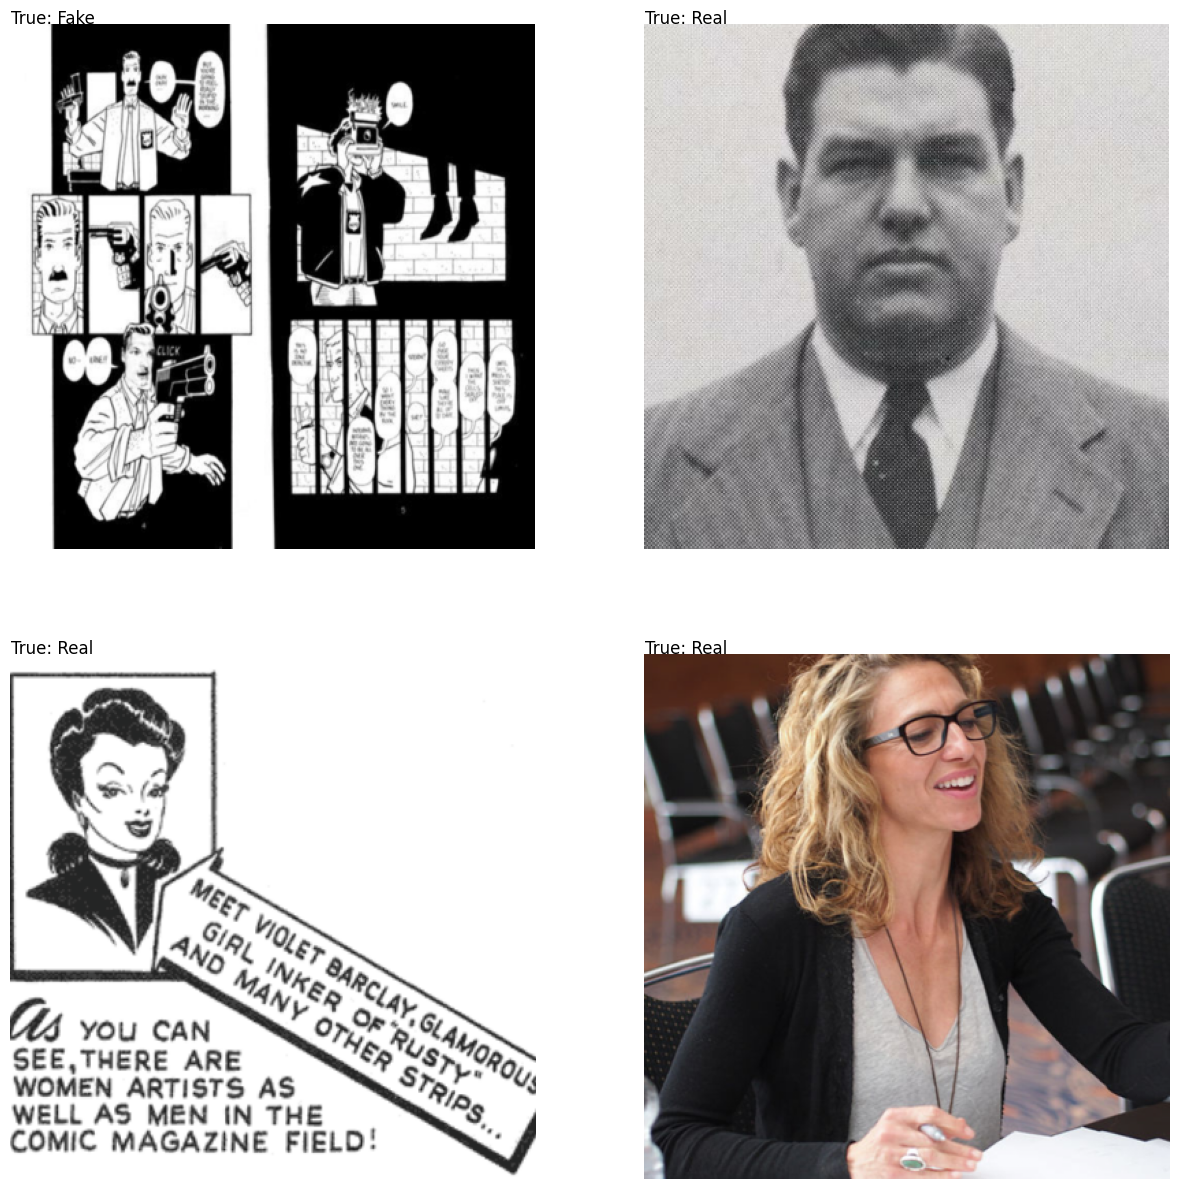

In [33]:
show_errors(
    best_model,
    dataloaders["no_augmentation"]["efficient_net"]["test"],
    class_mapping = {0: "Fake", 1: "Real"},
    num_examples=4,
    nrows=2,
    ncols=2,
)